# Attrition Model - Exploratory Data Analysis

## Project Description:

Definitions:
- `Attrition` is the departure of employees from the organization for any reason (voluntary or involuntary), including resignation, termination, death or retirement.


Assumptions:
- Ordinal metrics from 1-N showcase that 1 is a low value and N is a high value
    - JobLevel of 5 is like an executive. Range: [1,2,3,4, 5]
    - PerformanceRating of 4 is Great performance.  Range: [1,2,3,4]
    - JobSatisfaction of 4 is Great performance. Range: [1,2,3,4]
- EmployeeID is unique field




In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
import mlflow
import warnings

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'

# Show all columns
pd.set_option('display.max_columns', None)


In [4]:
random_state_var = 42
random_state_var

42

In [5]:
np.random.seed(random_state_var)


In [6]:
# Add my parent directory to path variables
current_location = Path(os.path.abspath('')).parent.resolve()
print(current_location)
sys.path.append(str(current_location))

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code


In [7]:
raw_data_dir = os.path.join(current_location, "raw_data")
os.makedirs(raw_data_dir, exist_ok=True)

transformed_data_dir = os.path.join(current_location, "transformed_data")
os.makedirs(transformed_data_dir, exist_ok=True)

output_data_dir = os.path.join(current_location, "output_data")
os.makedirs(output_data_dir, exist_ok=True)

## Connect to MLFlow:


### Ensure you run this once:

In [8]:
!mlflow.set_tracking_uri("file:///Users/ryanmccarlie/Documents/Problems/PwC%20Interview/Code/mlruns")

zsh:1: invalid mode specification


In [9]:
def get_or_create_experiment(experiment_name: str) -> str:
    """
    Fetches the experiment with the given name if it exists. If it doesn't exist, creates a new one.
    
    Parameters:
    - experiment_name (str): The name of the MLFlow experiment.
    
    Returns:
    - experiment_id (str): The ID of the experiment to use.
    """
    mlflow.set_tracking_uri("file:///Users/ryanmccarlie/Documents/Problems/PwC%20Interview/Code/mlruns")

    # Fetch the experiment if it exists
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is not None:
            print(f"Experiment '{experiment_name}' exists with ID: {experiment.experiment_id}")
            return experiment.experiment_id
        else:
            # Create a new experiment if it does not exist
            experiment_id = mlflow.create_experiment(experiment_name)
            print(f"Created new experiment '{experiment_name}' with ID: {experiment_id}")
            return experiment_id
    except mlflow.MlflowException as e:
        print(f"Error: {e}")
        raise

In [10]:
# Example usage
experiment_name = "Employee_Attrition_Experiment"

# Get or create the experiment
experiment_id = get_or_create_experiment(experiment_name)

# Set the experiment ID for subsequent logging
mlflow.set_experiment(experiment_id=experiment_id)

Experiment 'Employee_Attrition_Experiment' exists with ID: 127905123878869483


<Experiment: artifact_location='file:///Users/ryanmccarlie/Documents/Problems/PwC%20Interview/Code/mlruns/127905123878869483', creation_time=1726585527884, experiment_id='127905123878869483', last_update_time=1726585527884, lifecycle_stage='active', name='Employee_Attrition_Experiment', tags={}>

## 1. Read in Data

In [11]:
attrition_fname = os.path.join(raw_data_dir, "employee_attrition_data_final.xlsx")
employee_attribution_data = pd.read_excel(attrition_fname)

print(employee_attribution_data.columns)
print(employee_attribution_data.shape)
employee_attribution_data.head()

Index(['EmployeeID', 'Age', 'Gender', 'Department', 'Education',
       'MaritalStatus', 'YearsAtCompany', 'JobRole', 'MonthlyIncome',
       'OverTime', 'BusinessTravel', 'DistanceFromHome', 'JobLevel',
       'PercentSalaryHike', 'PerformanceRating', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobSatisfaction',
       'Attrition'],
      dtype='object')
(5000, 20)


,EmployeeID,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
0,1,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,9,4,24,2,2.0,1.0,0,1,No
1,2,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,39,1,20,1,14.0,11.0,7,1,No
2,3,32.0,Male,HR,PhD,Single,35.0,Clerk,7357,No,Non-Travel,1,1,12,1,11.0,7.0,0,4,Yes
3,4,60.0,Male,Support,PhD,Single,39.0,Technician,2327,Yes,Travel_Rarely,33,1,0,2,12.0,6.0,5,"""3.00""",Yes
4,5,25.0,Male,Support,High School,Single,14.0,Executive,12285,Yes,Travel_Rarely,38,5,24,3,9.0,4.0,9,3,Yes


In [12]:
assert employee_attribution_data["EmployeeID"].is_unique

In [13]:
if employee_attribution_data["EmployeeID"].is_unique:
    employee_attribution_data = employee_attribution_data.drop(columns=["EmployeeID"])
    
employee_attribution_data.head(2)

,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
0,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,9,4,24,2,2.0,1.0,0,1,No
1,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,39,1,20,1,14.0,11.0,7,1,No


In [14]:
list(employee_attribution_data.columns)

['Age',
 'Gender',
 'Department',
 'Education',
 'MaritalStatus',
 'YearsAtCompany',
 'JobRole',
 'MonthlyIncome',
 'OverTime',
 'BusinessTravel',
 'DistanceFromHome',
 'JobLevel',
 'PercentSalaryHike',
 'PerformanceRating',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'JobSatisfaction',
 'Attrition']

In [15]:
employee_attribution_data.dtypes.to_dict()

{'Age': dtype('float64'),
 'Gender': dtype('O'),
 'Department': dtype('O'),
 'Education': dtype('O'),
 'MaritalStatus': dtype('O'),
 'YearsAtCompany': dtype('float64'),
 'JobRole': dtype('O'),
 'MonthlyIncome': dtype('int64'),
 'OverTime': dtype('O'),
 'BusinessTravel': dtype('O'),
 'DistanceFromHome': dtype('int64'),
 'JobLevel': dtype('O'),
 'PercentSalaryHike': dtype('int64'),
 'PerformanceRating': dtype('O'),
 'YearsInCurrentRole': dtype('float64'),
 'YearsSinceLastPromotion': dtype('float64'),
 'YearsWithCurrManager': dtype('int64'),
 'JobSatisfaction': dtype('O'),
 'Attrition': dtype('O')}

In [16]:
target_class = "Attrition"
employee_attribution_data[target_class].value_counts()

Attrition
No     3149
Yes    1851
Name: count, dtype: int64

In [17]:
employee_attribution_data.describe()

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,PercentSalaryHike,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,4997.000000,4992.000000,5.000000e+03,5000.000000,5000.000000,4998.000000,4997.000000,5000.000000
mean,41.243346,35.735777,1.157740e+04,24.990600,21.964600,20.757303,12.303582,11.911800
std,13.676054,399.376981,2.607094e+04,14.089436,315.774936,286.886692,202.894029,198.255181
min,4.000000,0.000000,2.000000e+03,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,10.000000,6.642000e+03,13.000000,6.000000,2.250000,1.000000,1.000000
50%,41.000000,20.000000,1.115200e+04,25.000000,12.000000,7.000000,3.000000,3.000000
75%,53.000000,30.000000,1.557850e+04,37.000000,18.000000,15.000000,7.000000,7.000000
max,99.000000,9999.000000,1.532624e+06,49.000000,9999.000000,9590.000000,7359.000000,7444.000000


## Notes:
- looks like w have some anomalies in the max values column for sure

## 2. Data Cleaning

### 2.1 Correct String Values in Numeric Columns

In [18]:
corrected_df = employee_attribution_data.copy()

corrected_df.shape

(5000, 19)

In [19]:
from utils.cleaning import identify_numeric_columns_with_object_type, correct_numeric_columns_with_object_type

columns_w_string_values = identify_numeric_columns_with_object_type(corrected_df)
print(f"columns_w_string_values: {columns_w_string_values}")

columns_w_string_values: ['JobLevel', 'PerformanceRating', 'JobSatisfaction']


In [20]:
corrected_df[~corrected_df["JobSatisfaction"].isin([1,2,3,4,5])]["JobSatisfaction"].values

array(['"3.00"', '"3.00"', '"2.00"', '"2.00"', '"3.00"', '"2.00"',
       '"2.00"', '"3.00"', '"2.00"', '"2.00"'], dtype=object)

In [21]:
corrected_df["JobSatisfaction"].dtypes

dtype('O')

In [22]:
for col_name in columns_w_string_values:    
    corrected_df.loc[:, col_name] = corrected_df[col_name].apply(correct_numeric_columns_with_object_type)
    corrected_df[col_name] = pd.to_numeric(corrected_df[col_name])

In [23]:
print(corrected_df.shape)

print(corrected_df["JobSatisfaction"].dtypes)
corrected_df[~corrected_df["JobSatisfaction"].isin([1,2,3,4,5])]["JobSatisfaction"].values

(5000, 19)
float64


array([], dtype=float64)

In [24]:
corrected_df.dtypes

Age                        float64
Gender                      object
Department                  object
Education                   object
MaritalStatus               object
YearsAtCompany             float64
JobRole                     object
MonthlyIncome                int64
OverTime                    object
BusinessTravel              object
DistanceFromHome             int64
JobLevel                   float64
PercentSalaryHike            int64
PerformanceRating          float64
YearsInCurrentRole         float64
YearsSinceLastPromotion    float64
YearsWithCurrManager         int64
JobSatisfaction            float64
Attrition                   object
dtype: object

### 2.2 Remove NaN Values

In [25]:
corrected_df.shape

(5000, 19)

In [26]:
nan_columns = corrected_df.columns[corrected_df.isna().any()].tolist()
print("nan_columns", nan_columns)

corrected_df.isnull().sum()  # Check for missing values

nan_columns ['Age', 'YearsAtCompany', 'PerformanceRating', 'YearsInCurrentRole', 'YearsSinceLastPromotion']


Age                        3
Gender                     0
Department                 0
Education                  0
MaritalStatus              0
YearsAtCompany             8
JobRole                    0
MonthlyIncome              0
OverTime                   0
BusinessTravel             0
DistanceFromHome           0
JobLevel                   0
PercentSalaryHike          0
PerformanceRating          2
YearsInCurrentRole         2
YearsSinceLastPromotion    3
YearsWithCurrManager       0
JobSatisfaction            0
Attrition                  0
dtype: int64

In [27]:
print(corrected_df[corrected_df.isna().any(axis=1)].shape)
corrected_df[corrected_df.isna().any(axis=1)]


(18, 19)


,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
8,40.0,Female,HR,High School,Single,NaN,Engineer,17540,No,Travel_Rarely,32,2.0,12,4.0,0.0,0.0,0,2.0,Yes
358,57.0,Female,Sales,High School,Divorced,NaN,Clerk,19916,No,Travel_Frequently,48,3.0,21,4.0,0.0,0.0,0,3.0,No
1058,50.0,Male,Sales,Bachelors,Divorced,NaN,Manager,7789,Yes,Travel_Frequently,12,2.0,9,4.0,0.0,0.0,0,4.0,Yes
1863,19.0,Male,Support,Bachelors,Divorced,NaN,Manager,14571,Yes,Travel_Rarely,22,1.0,15,3.0,0.0,0.0,0,1.0,No
1914,NaN,Male,Development,Masters,Married,26.0,Engineer,17473,Yes,Travel_Frequently,47,4.0,0,1.0,10.0,8.0,5,1.0,No
1999,23.0,Female,Finance,Bachelors,Divorced,8.0,Clerk,16262,Yes,Travel_Rarely,21,1.0,19,4.0,NaN,3.0,0,2.0,Yes
2493,42.0,Male,Development,Bachelors,Married,NaN,Manager,8673,Yes,Non-Travel,35,5.0,9,2.0,0.0,0.0,0,2.0,Yes
2734,45.0,Female,Development,Bachelors,Divorced,23.0,Technician,18966,Yes,Non-Travel,18,3.0,1,4.0,NaN,7.0,11,3.0,No
2909,18.0,Female,Sales,Bachelors,Married,2.0,Manager,11291,No,Travel_Frequently,41,3.0,1,NaN,2.0,2.0,1,2.0,No
3124,51.0,Female,Support,PhD,Divorced,NaN,Clerk,13180,No,Travel_Frequently,15,5.0,14,1.0,0.0,0.0,0,4.0,Yes


In [28]:
# Fill missing values
from utils.cleaning import fill_missing_values

df_no_nan = fill_missing_values(corrected_df)
df_no_nan.isnull().sum()

Age                        0
YearsAtCompany             0
MonthlyIncome              0
DistanceFromHome           0
JobLevel                   0
PercentSalaryHike          0
PerformanceRating          0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
JobSatisfaction            0
Gender                     0
Department                 0
Education                  0
MaritalStatus              0
JobRole                    0
OverTime                   0
BusinessTravel             0
Attrition                  0
dtype: int64

In [29]:
print(df_no_nan.shape)
df_no_nan[df_no_nan.isna().any(axis=1)]

(5000, 19)


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,Attrition


### 2.3 YearsAtCompany Feature Cleaning


Remove all employees which have 0 years worked

Why?
- Either (1) these values are a bug or (2) the employee has worked less that 6 months.
    - In the first case, remove data.
    - In the second case, then these data points are not adding value to the model to identify for historic trends or relationships. New employees will have highly variable features which will not be a true representation of their ability or true meaning.

In [30]:
df_no_nan[df_no_nan['YearsAtCompany'] > 0].shape

(4893, 19)

In [31]:
print(f"Dropped {df_no_nan[df_no_nan['YearsAtCompany'] <= 0].shape[0]} rows")
df_no_nan = df_no_nan[df_no_nan['YearsAtCompany'] > 0]

print(df_no_nan.shape)
df_no_nan.head(2)

Dropped 107 rows
(4893, 19)


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,Attrition
0,56.0,9.0,19844.0,9.0,4.0,24.0,2.0,2.0,1.0,0.0,1.0,Male,Support,Masters,Married,Technician,No,Travel_Frequently,No
1,46.0,29.0,6687.0,39.0,1.0,20.0,1.0,14.0,11.0,7.0,1.0,Female,Sales,Bachelors,Single,Engineer,No,Non-Travel,No


In [32]:
df_no_nan.dtypes

Age                        float64
YearsAtCompany             float64
MonthlyIncome              float64
DistanceFromHome           float64
JobLevel                   float64
PercentSalaryHike          float64
PerformanceRating          float64
YearsInCurrentRole         float64
YearsSinceLastPromotion    float64
YearsWithCurrManager       float64
JobSatisfaction            float64
Gender                      object
Department                  object
Education                   object
MaritalStatus               object
JobRole                     object
OverTime                    object
BusinessTravel              object
Attrition                   object
dtype: object

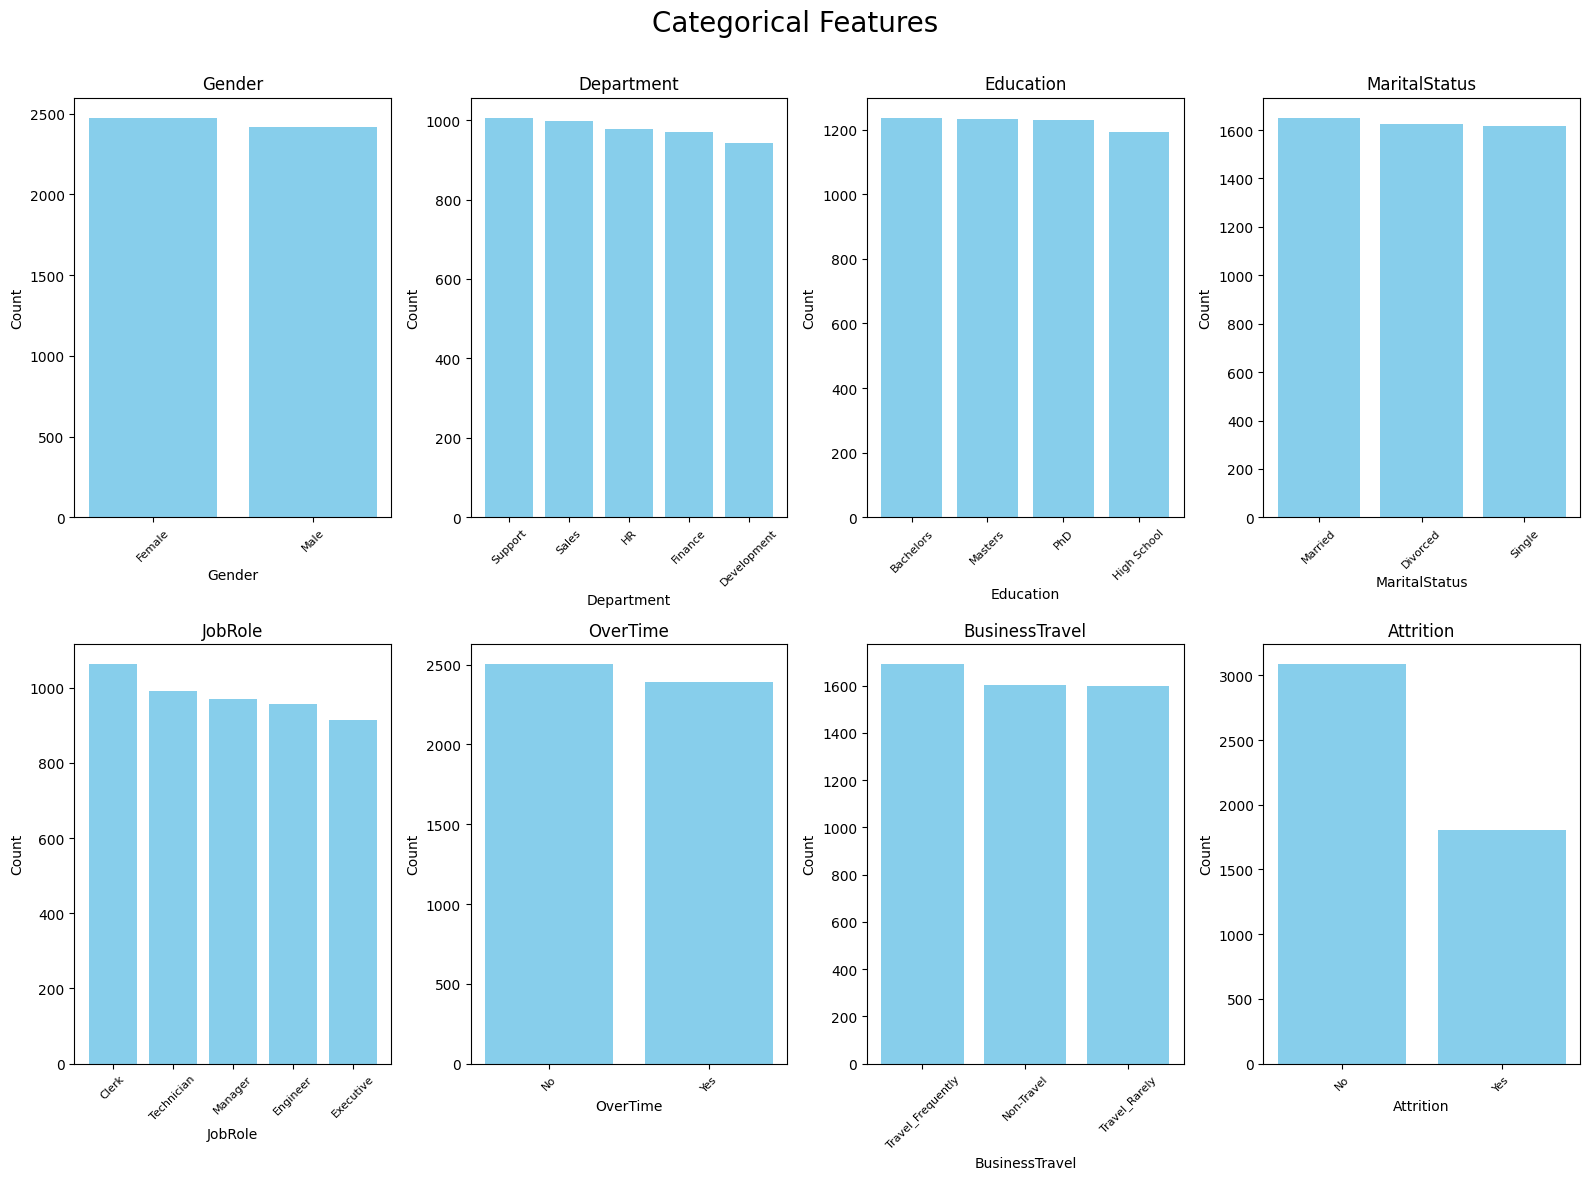

In [33]:
from utils.visualisation import plot_categorical_columns

# Plot bar charts for categorical columns
plot_categorical_columns(df_no_nan, width=16, height_per_row=6)

### 2.4 Apply Outlier Detection

In [34]:
df_pre_outliers_removed = df_no_nan.copy()
df_pre_outliers_removed.shape

(4893, 19)

In [35]:
# 'Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
#        'JobLevel', 'PercentSalaryHike', 'PerformanceRating',
#        'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
#        'JobSatisfaction', 'Gender', 'Department', 'Education', 'MaritalStatus',
#        'JobRole', 'OverTime', 'BusinessTravel', 'Attrition',

In [36]:
df_pre_outliers_removed['JobLevel'] = df_pre_outliers_removed['JobLevel'].astype('category')
df_pre_outliers_removed['PerformanceRating'] = df_pre_outliers_removed['PerformanceRating'].astype('category')
df_pre_outliers_removed['JobSatisfaction'] = df_pre_outliers_removed['JobSatisfaction'].astype('category')

df_pre_outliers_removed.dtypes

Age                         float64
YearsAtCompany              float64
MonthlyIncome               float64
DistanceFromHome            float64
JobLevel                   category
PercentSalaryHike           float64
PerformanceRating          category
YearsInCurrentRole          float64
YearsSinceLastPromotion     float64
YearsWithCurrManager        float64
JobSatisfaction            category
Gender                       object
Department                   object
Education                    object
MaritalStatus                object
JobRole                      object
OverTime                     object
BusinessTravel               object
Attrition                    object
dtype: object

In [37]:
categorical_columns = df_pre_outliers_removed.select_dtypes(include=['object', 'category']).columns
print("categorical_columns", categorical_columns)
print()

numeric_columns = df_pre_outliers_removed.select_dtypes(include=['float64', 'int64']).columns
print("numeric_columns", numeric_columns)

assert df_pre_outliers_removed.shape[1] == (len(numeric_columns) + len(categorical_columns))

categorical_columns Index(['JobLevel', 'PerformanceRating', 'JobSatisfaction', 'Gender',
       'Department', 'Education', 'MaritalStatus', 'JobRole', 'OverTime',
       'BusinessTravel', 'Attrition'],
      dtype='object')

numeric_columns Index(['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
       'PercentSalaryHike', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


Column: Age


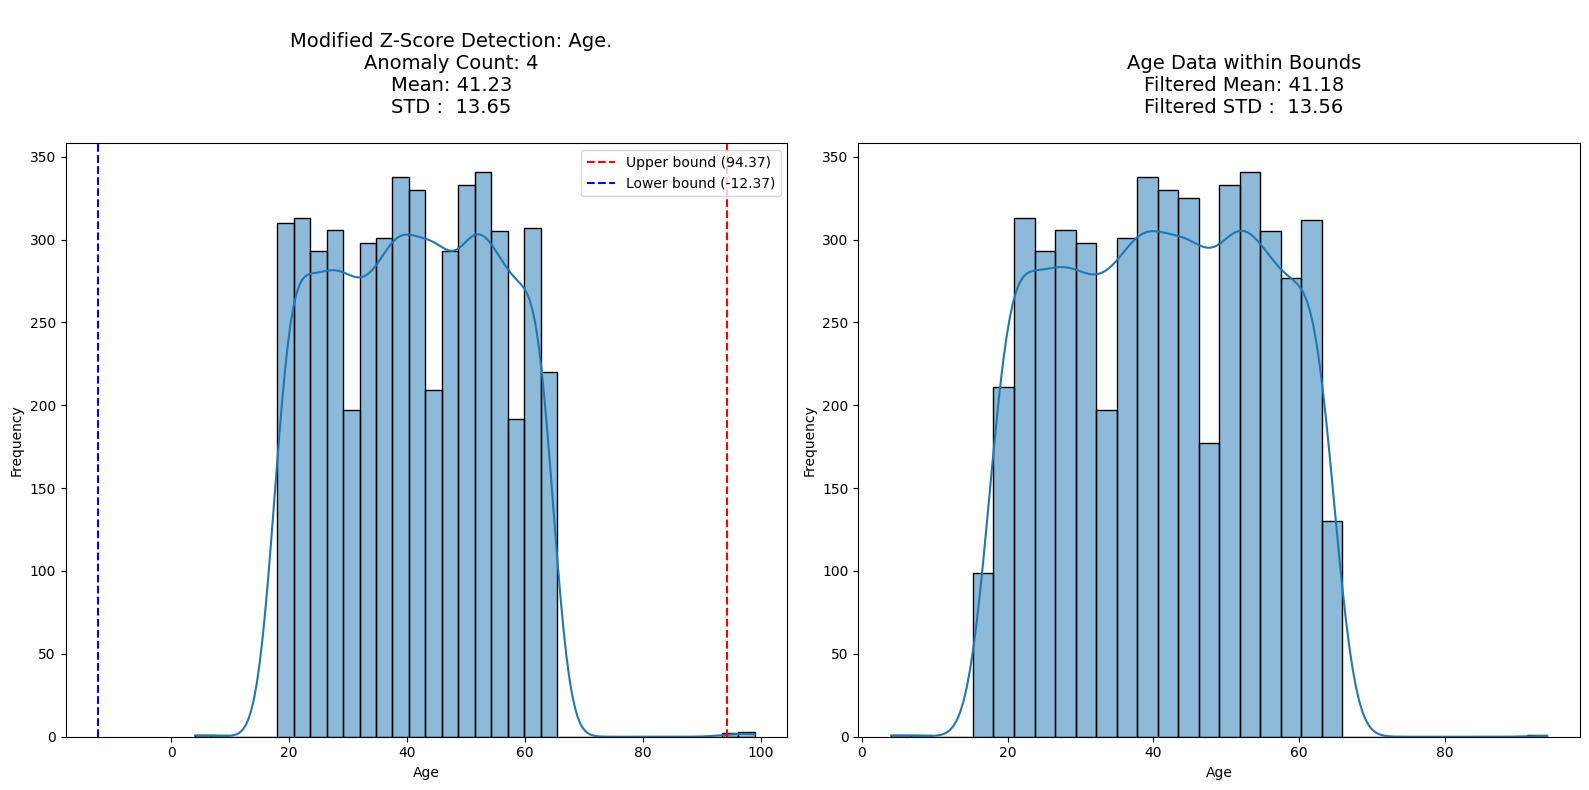

Column: YearsAtCompany


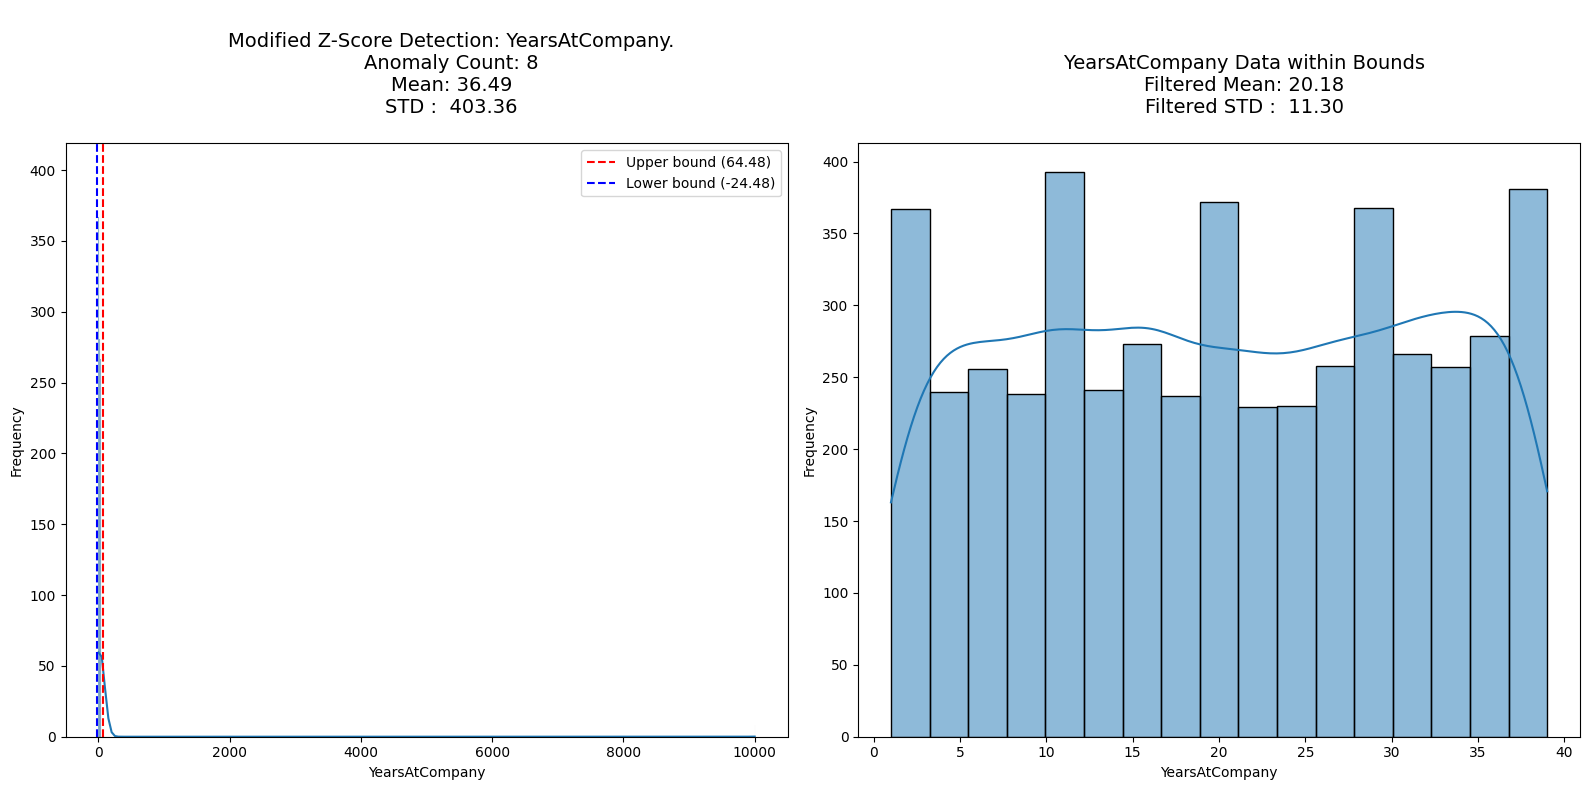

Column: MonthlyIncome


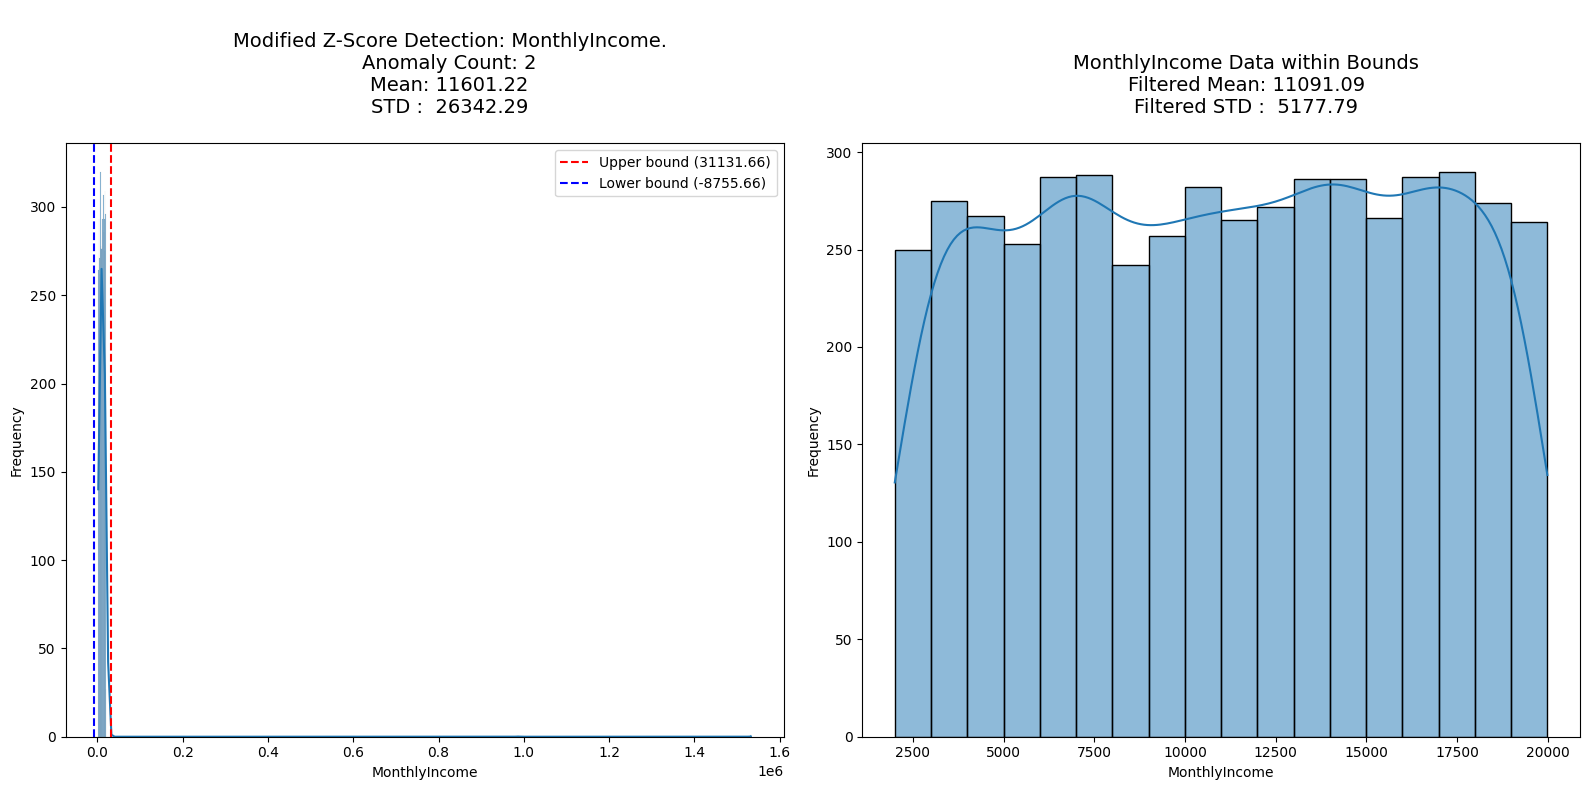

Column: DistanceFromHome


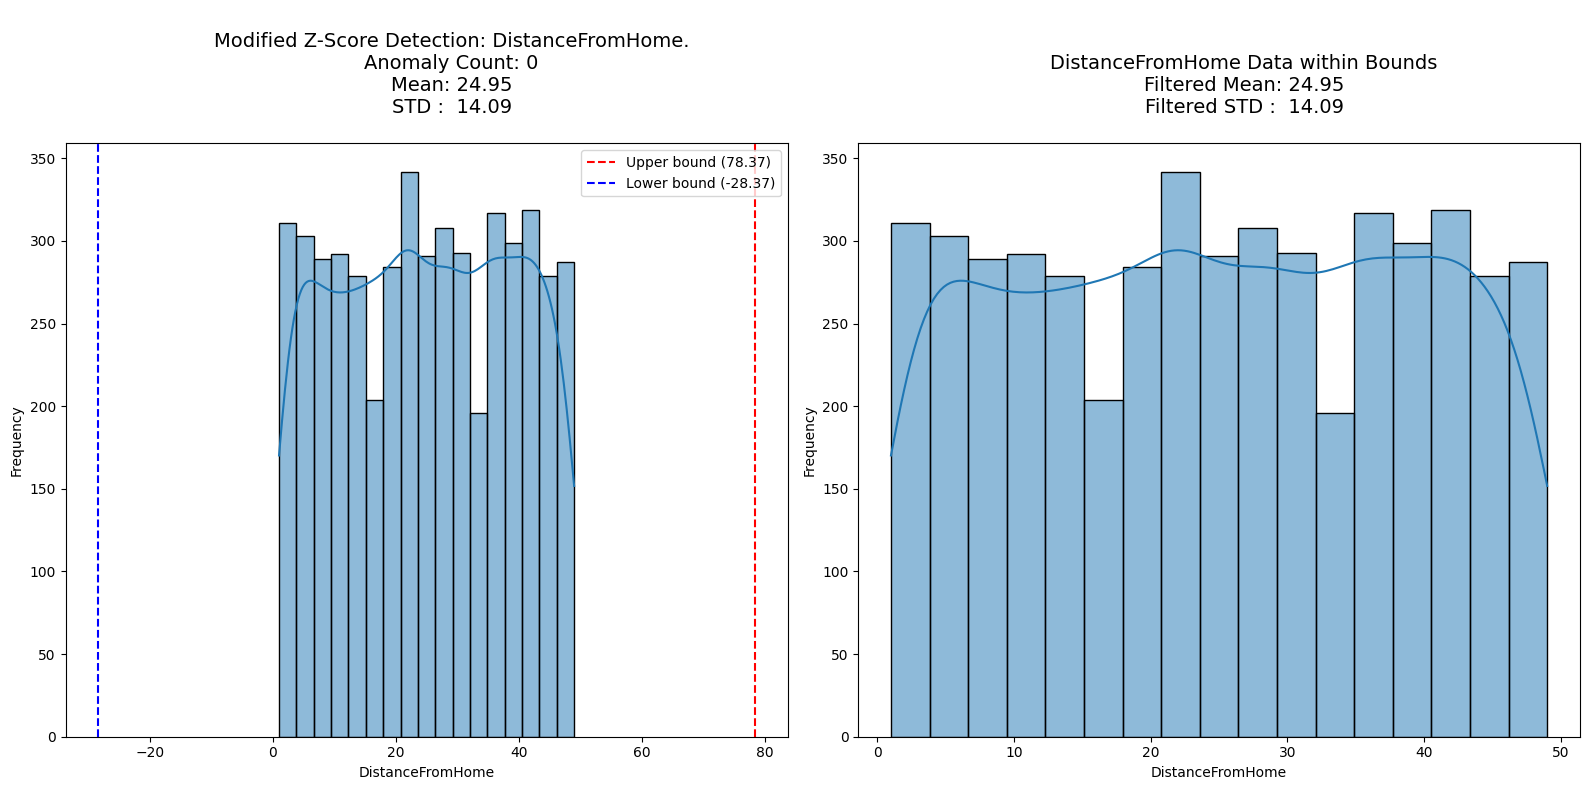

Column: PercentSalaryHike


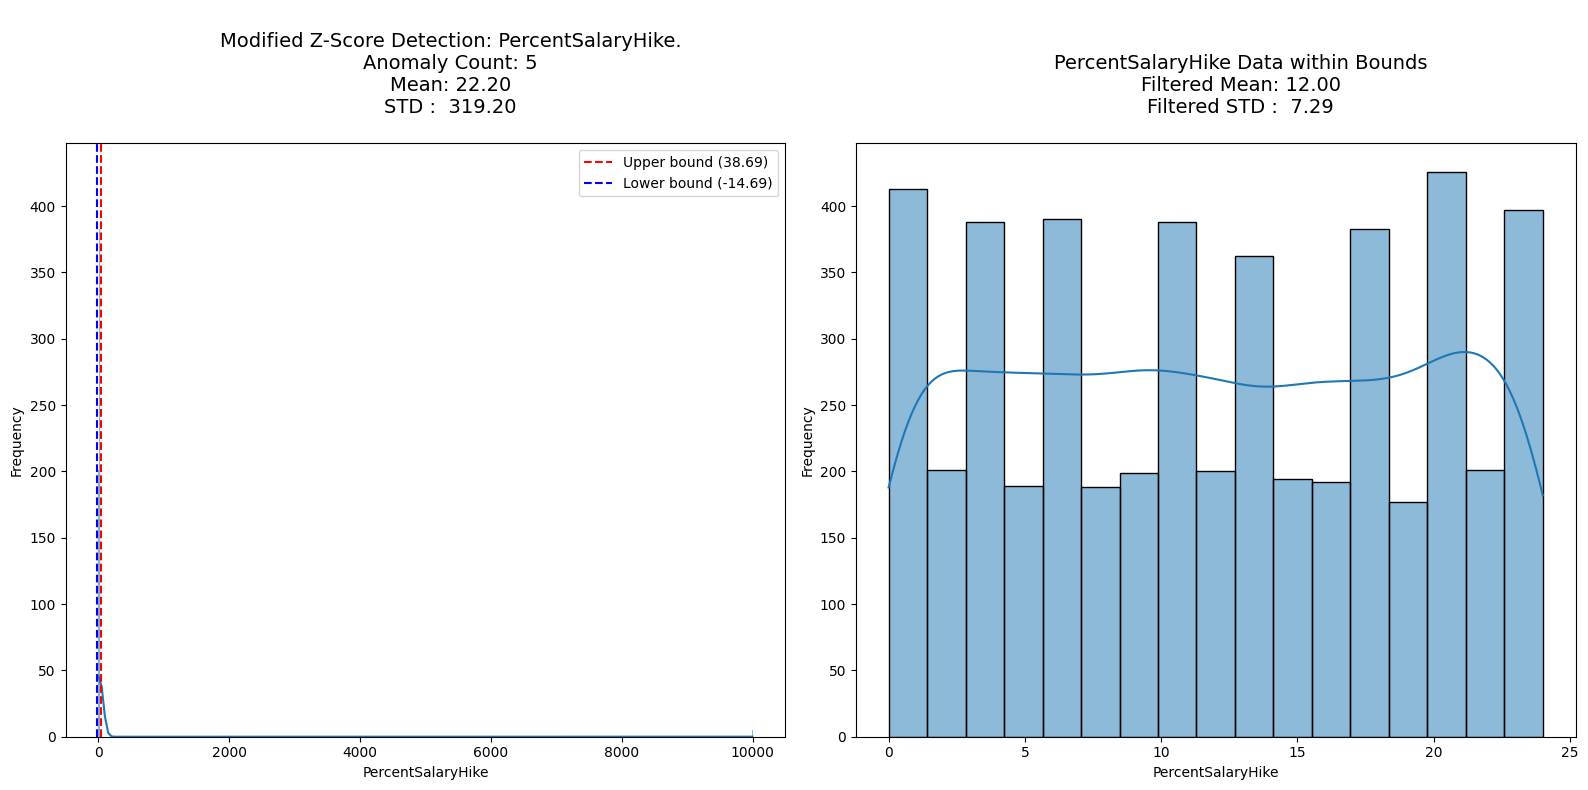

Column: YearsInCurrentRole


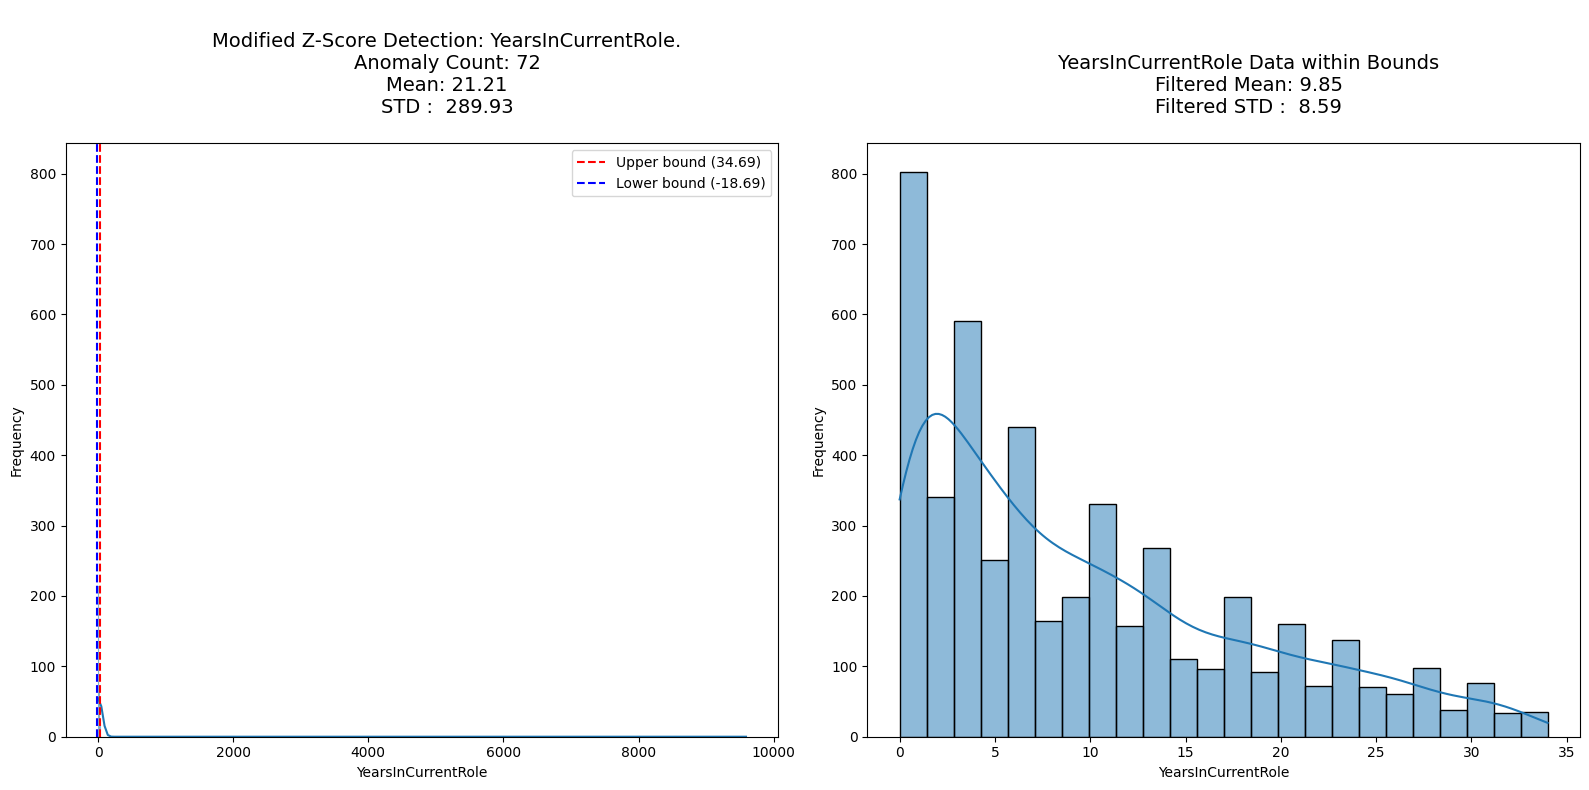

Column: YearsSinceLastPromotion


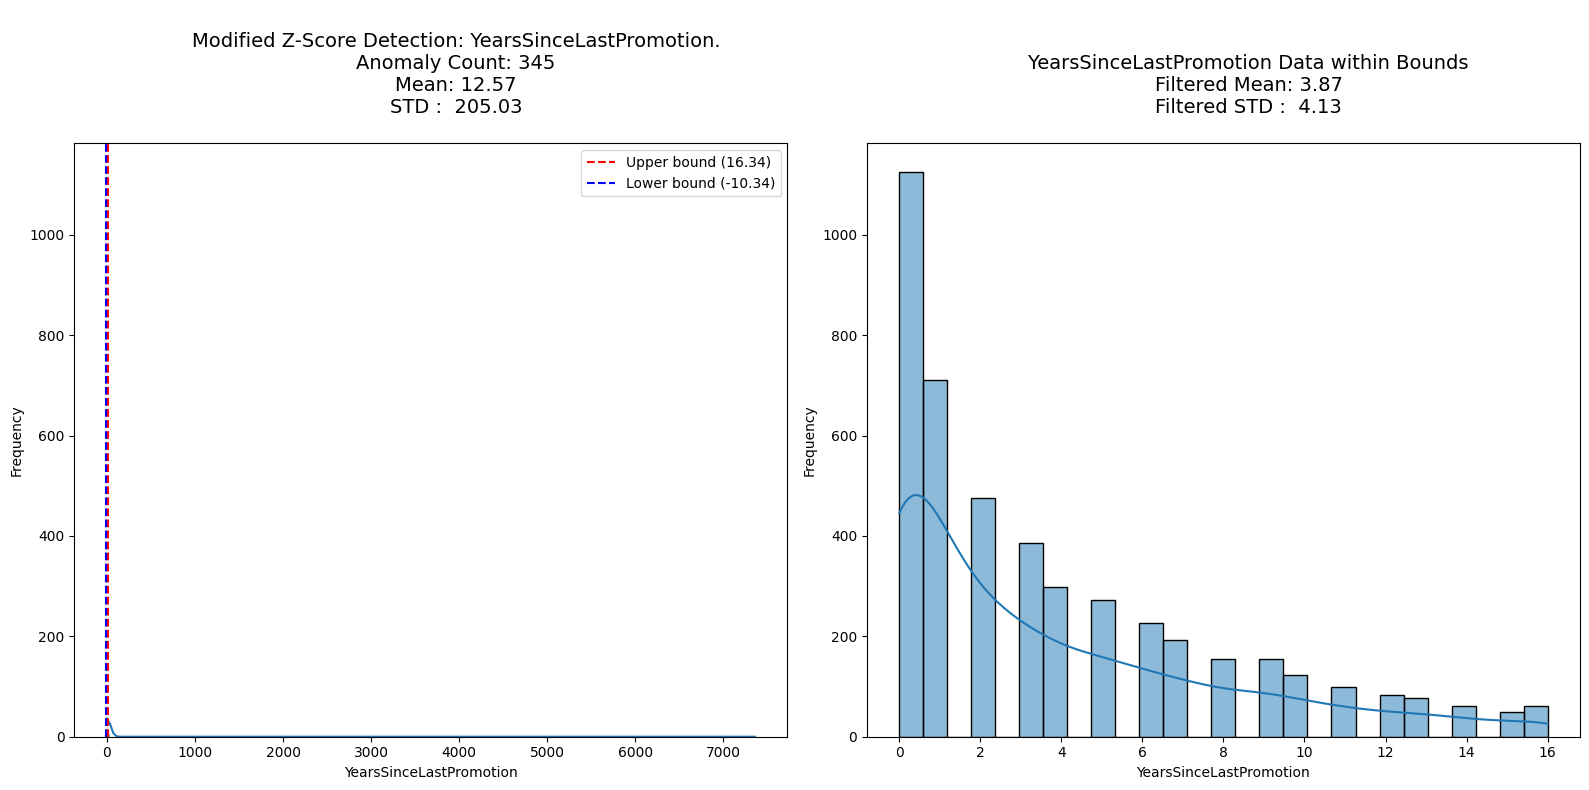

Column: YearsWithCurrManager


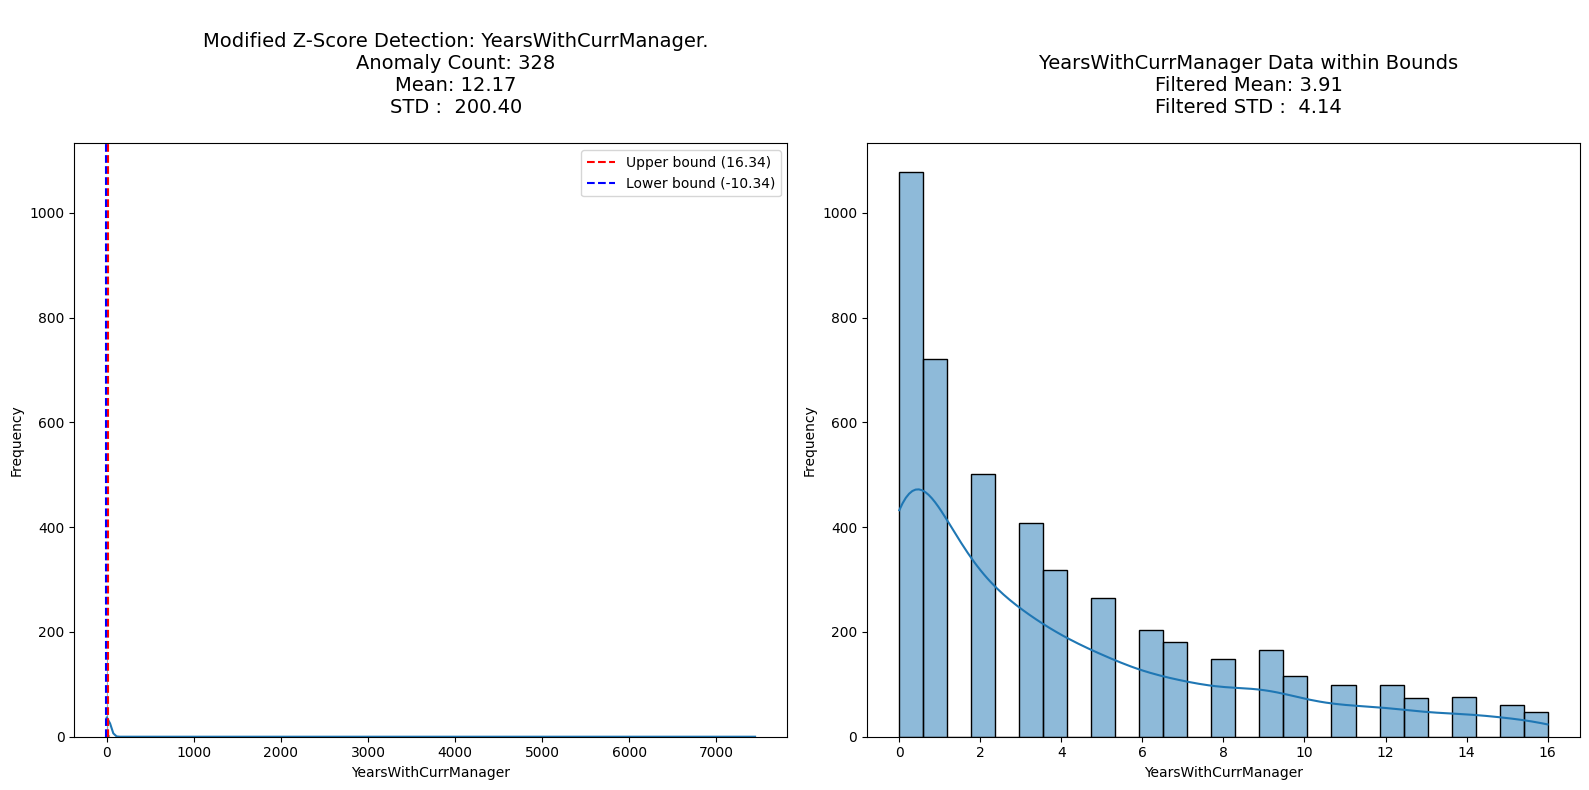

In [38]:
# Perform Modified Z-score anomaly detection
from utils.cleaning import modified_z_score_anomaly_detection
from utils.visualisation import plot_anomaly_detection_results

plot_zscore_anomalies = True
threshold = 3.0

for column in numeric_columns:
    # Calculate MAD stats
    df = modified_z_score_anomaly_detection(df_pre_outliers_removed, column, threshold)

    # Plot if requested
    if plot_zscore_anomalies:
        print(f"Column: {column}")        
        plot_anomaly_detection_results(df_pre_outliers_removed, column, threshold, figsize=(16, 8))
        plt.show()

In [39]:
df_pre_outliers_removed.columns

Index(['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
       'JobLevel', 'PercentSalaryHike', 'PerformanceRating',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobSatisfaction', 'Gender', 'Department', 'Education', 'MaritalStatus',
       'JobRole', 'OverTime', 'BusinessTravel', 'Attrition',
       'modified_z_score_Age', 'anomaly_Age',
       'modified_z_score_YearsAtCompany', 'anomaly_YearsAtCompany',
       'modified_z_score_MonthlyIncome', 'anomaly_MonthlyIncome',
       'modified_z_score_DistanceFromHome', 'anomaly_DistanceFromHome',
       'modified_z_score_PercentSalaryHike', 'anomaly_PercentSalaryHike',
       'modified_z_score_YearsInCurrentRole', 'anomaly_YearsInCurrentRole',
       'modified_z_score_YearsSinceLastPromotion',
       'anomaly_YearsSinceLastPromotion',
       'modified_z_score_YearsWithCurrManager',
       'anomaly_YearsWithCurrManager'],
      dtype='object')

In [40]:
anomaly_columns = [col for col in df_pre_outliers_removed.columns if col.startswith("anomaly")]
anomaly_columns

['anomaly_Age',
 'anomaly_YearsAtCompany',
 'anomaly_MonthlyIncome',
 'anomaly_DistanceFromHome',
 'anomaly_PercentSalaryHike',
 'anomaly_YearsInCurrentRole',
 'anomaly_YearsSinceLastPromotion',
 'anomaly_YearsWithCurrManager']

In [41]:
from utils.cleaning import filter_anomalies


df_no_anomalies = filter_anomalies(
    df=df_pre_outliers_removed,
    anomaly_columns=anomaly_columns,
)

print(df_no_anomalies.shape)
df_no_anomalies.head()

(4331, 35)


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,Attrition,modified_z_score_Age,anomaly_Age,modified_z_score_YearsAtCompany,anomaly_YearsAtCompany,modified_z_score_MonthlyIncome,anomaly_MonthlyIncome,modified_z_score_DistanceFromHome,anomaly_DistanceFromHome,modified_z_score_PercentSalaryHike,anomaly_PercentSalaryHike,modified_z_score_YearsInCurrentRole,anomaly_YearsInCurrentRole,modified_z_score_YearsSinceLastPromotion,anomaly_YearsSinceLastPromotion,modified_z_score_YearsWithCurrManager,anomaly_YearsWithCurrManager
0,56.0,9.0,19844.0,9.0,4.0,24.0,2.0,2.0,1.0,0.0,1.0,Male,Support,Masters,Married,Technician,No,Travel_Frequently,No,0.843125,False,-0.74195,False,1.302068,False,-0.899333,False,1.349000,False,-0.674500,False,-0.449667,False,-0.674500,False
1,46.0,29.0,6687.0,39.0,1.0,20.0,1.0,14.0,11.0,7.0,1.0,Female,Sales,Bachelors,Single,Engineer,No,Non-Travel,No,0.281042,False,0.60705,False,-0.677057,False,0.786917,False,0.899333,False,0.674500,False,1.798667,False,0.899333,False
2,32.0,35.0,7357.0,1.0,1.0,12.0,1.0,11.0,7.0,0.0,4.0,Male,HR,PhD,Single,Clerk,No,Non-Travel,Yes,-0.505875,False,1.01175,False,-0.576273,False,-1.349000,False,0.000000,False,0.337250,False,0.899333,False,-0.674500,False
3,60.0,39.0,2327.0,33.0,1.0,0.0,2.0,12.0,6.0,5.0,3.0,Male,Support,PhD,Single,Technician,Yes,Travel_Rarely,Yes,1.067958,False,1.28155,False,-1.332905,False,0.449667,False,-1.349000,False,0.449667,False,0.674500,False,0.449667,False
4,25.0,14.0,12285.0,38.0,5.0,24.0,3.0,9.0,4.0,9.0,3.0,Male,Support,High School,Single,Executive,Yes,Travel_Rarely,Yes,-0.899333,False,-0.40470,False,0.165015,False,0.730708,False,1.349000,False,0.112417,False,0.224833,False,1.349000,False


In [42]:
# Clean up Cols

z_score_col_names = [col for col in df_no_anomalies.columns if col.startswith("modified_z_score_")]
anomaly_column_names = [col for col in df_no_anomalies.columns if col.startswith("anomaly")]
cos_to_drop = z_score_col_names + anomaly_column_names


df_no_anomalies_cleaned = df_no_anomalies.drop(
    columns=cos_to_drop, 
    # errors="ignore"
)
print(f"Dropped all columns:\n", z_score_col_names)
print(f"Dropped all columns:\n", anomaly_column_names)

Dropped all columns:
 ['modified_z_score_Age', 'modified_z_score_YearsAtCompany', 'modified_z_score_MonthlyIncome', 'modified_z_score_DistanceFromHome', 'modified_z_score_PercentSalaryHike', 'modified_z_score_YearsInCurrentRole', 'modified_z_score_YearsSinceLastPromotion', 'modified_z_score_YearsWithCurrManager']
Dropped all columns:
 ['anomaly_Age', 'anomaly_YearsAtCompany', 'anomaly_MonthlyIncome', 'anomaly_DistanceFromHome', 'anomaly_PercentSalaryHike', 'anomaly_YearsInCurrentRole', 'anomaly_YearsSinceLastPromotion', 'anomaly_YearsWithCurrManager']


In [43]:
df_no_anomalies_cleaned.tail()

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,Attrition
4994,20.0,35.0,19280.0,34.0,5.0,19.0,2.0,1.0,1.0,1.0,3.0,Male,HR,PhD,Divorced,Manager,No,Travel_Frequently,No
4995,33.0,6.0,8345.0,23.0,1.0,14.0,3.0,1.0,0.0,1.0,2.0,Female,HR,Masters,Married,Executive,Yes,Travel_Frequently,No
4996,22.0,22.0,15322.0,49.0,2.0,24.0,2.0,5.0,1.0,3.0,4.0,Male,Finance,Bachelors,Single,Technician,No,Travel_Frequently,Yes
4998,27.0,31.0,18398.0,19.0,5.0,15.0,4.0,29.0,4.0,12.0,2.0,Female,Finance,High School,Married,Technician,Yes,Non-Travel,Yes
4999,36.0,20.0,13320.0,37.0,4.0,6.0,2.0,17.0,16.0,0.0,3.0,Female,Development,High School,Married,Technician,No,Non-Travel,No


In [44]:
mean_num_since_promotion = df_no_anomalies_cleaned["YearsAtCompany"].mean()
mean_num_since_promotion

np.float64(18.67490187023782)

In [45]:
df_no_anomalies_cleaned["YearsAtCompany"].describe()

count    4331.000000
mean       18.674902
std        10.966233
min         1.000000
25%         9.000000
50%        18.000000
75%        28.000000
max        39.000000
Name: YearsAtCompany, dtype: float64

In [46]:
mean_num_since_promotion = df_no_anomalies_cleaned["YearsWithCurrManager"].mean()
mean_num_since_promotion

np.float64(3.6970676518125143)

In [47]:
mean_num_since_promotion = df_no_anomalies_cleaned["YearsInCurrentRole"].mean()
mean_num_since_promotion

np.float64(8.145693835142)

In [48]:
mean_num_since_promotion = df_no_anomalies_cleaned["YearsSinceLastPromotion"].mean()
mean_num_since_promotion

np.float64(3.652966982221196)

## Note:

After Cleaning data - Looks about right.

In [49]:
def validate_columns_against_reference(df, reference_column, columns_to_check):
    """
    Adds a boolean feature `sanity_feature_value_check` that indicates if all values in
    the specified columns are less than or equal to the reference column.
    
    :param df: The DataFrame.
    :param reference_column: The column to use as the reference for the check.
    :param columns_to_check: A list of columns to compare against the reference column.
    :return: The DataFrame with the new sanity check feature.
    """
    # Initialize sanity_feature_value_check to True
    df['sanity_feature_value_check'] = True
    
    # Loop through the columns to check if any value is greater than the reference column
    for col in columns_to_check:
        # Check if each value in the column is less than or equal to the reference column, then update the sanity check column
        df['sanity_feature_value_check'] = df['sanity_feature_value_check'] & (df[col] <= df[reference_column])
    
    return df

In [50]:
df_no_anomalies_cleaned = validate_columns_against_reference(df_no_anomalies_cleaned, 'YearsAtCompany', ["YearsInCurrentRole", "YearsWithCurrManager", "YearsSinceLastPromotion"])
df_no_anomalies_cleaned["sanity_feature_value_check"].value_counts()

sanity_feature_value_check
True     4327
False       4
Name: count, dtype: int64

In [51]:
df_no_anomalies_cleaned[df_no_anomalies_cleaned["sanity_feature_value_check"] == False][["YearsAtCompany", "YearsInCurrentRole", "YearsWithCurrManager", "YearsSinceLastPromotion"]]

,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,YearsSinceLastPromotion
49,6.0,6.0,5.0,8.0
1479,2.0,1.0,4.0,1.0
3189,1.0,1.0,1.0,3.0
4161,14.0,17.0,15.0,14.0


In [52]:
df_no_anomalies_cleaned_sanity = df_no_anomalies_cleaned[df_no_anomalies_cleaned["sanity_feature_value_check"] == True]
df_no_anomalies_cleaned_sanity = df_no_anomalies_cleaned_sanity.drop(columns=["sanity_feature_value_check"])

print(df_no_anomalies_cleaned_sanity.shape)
df_no_anomalies_cleaned_sanity.tail(2)

(4327, 19)


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,Attrition
4998,27.0,31.0,18398.0,19.0,5.0,15.0,4.0,29.0,4.0,12.0,2.0,Female,Finance,High School,Married,Technician,Yes,Non-Travel,Yes
4999,36.0,20.0,13320.0,37.0,4.0,6.0,2.0,17.0,16.0,0.0,3.0,Female,Development,High School,Married,Technician,No,Non-Travel,No


## Notes:
- Issue here: we see there are 6 fields where the `YearsAtCompany` happens to be smaller than one of ["YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]


1x very good example is:
- A person who has been at the company for 6 years, and has been 6 years in their current role, has had 8 years since their last promotion. That is impossible
- (OLD) Age of person is 30 but they have worked 35 years at the company (make a joke here - would fit suitably within the latest demanding job craze :D)


Conclusion:
- Dropping these rows since the data is not making sense

## Plot Categorical and Numerical Features Against Target

In [53]:
numeric_columns

Index(['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
       'PercentSalaryHike', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/utils/visualisation.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numeric_feature, data=df, palette={'Yes': 'lightblue', 'No': 'lightcoral'})


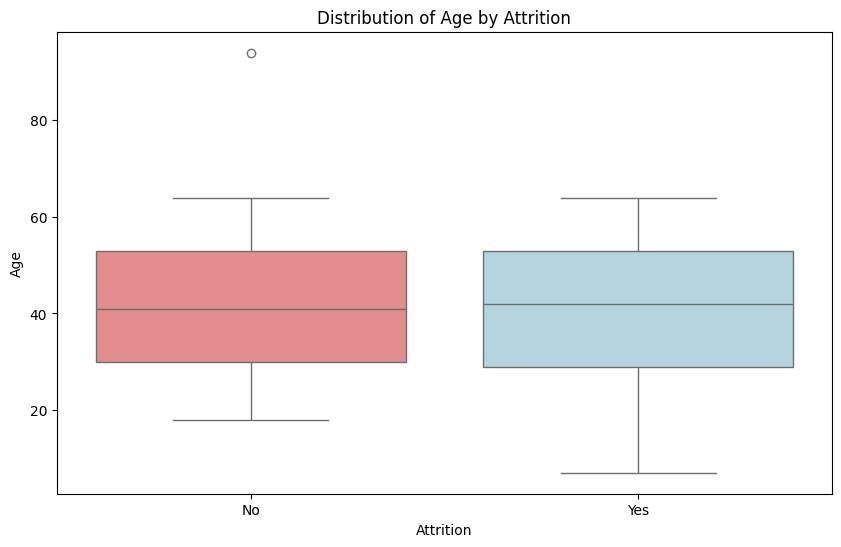

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/utils/visualisation.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numeric_feature, data=df, palette={'Yes': 'lightblue', 'No': 'lightcoral'})


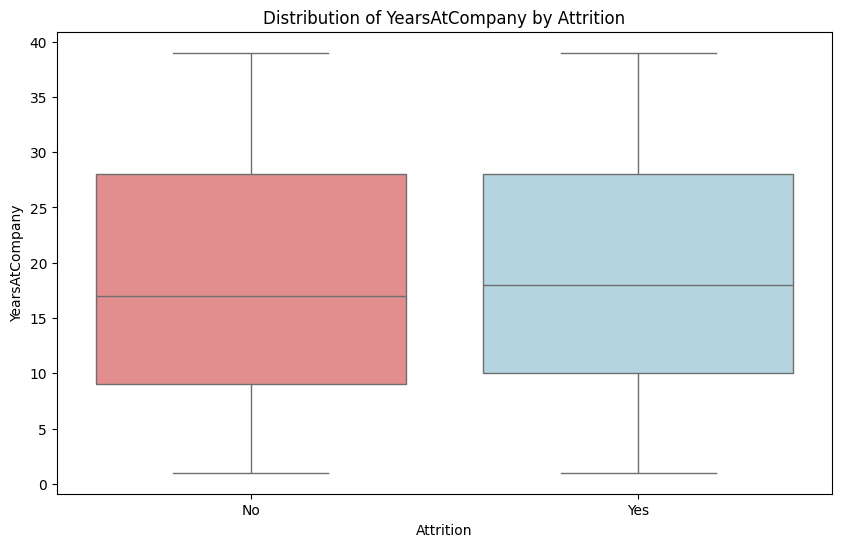

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/utils/visualisation.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numeric_feature, data=df, palette={'Yes': 'lightblue', 'No': 'lightcoral'})


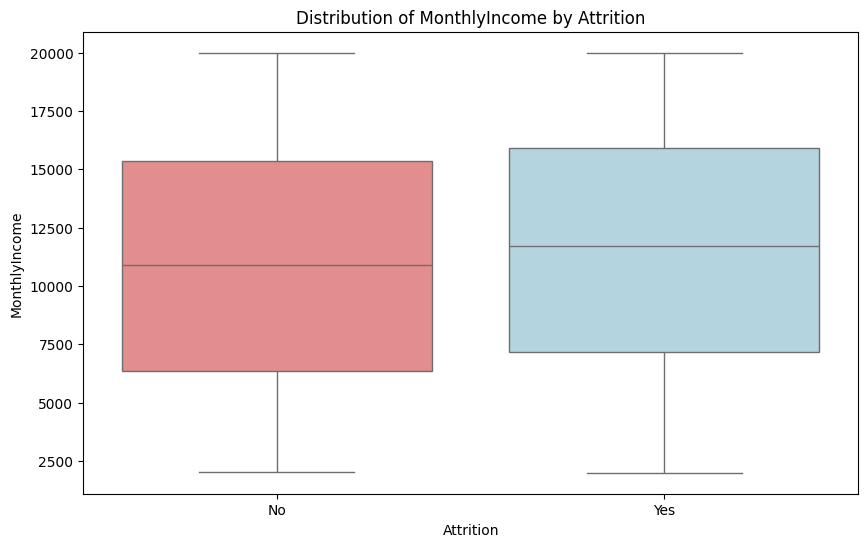

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/utils/visualisation.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numeric_feature, data=df, palette={'Yes': 'lightblue', 'No': 'lightcoral'})


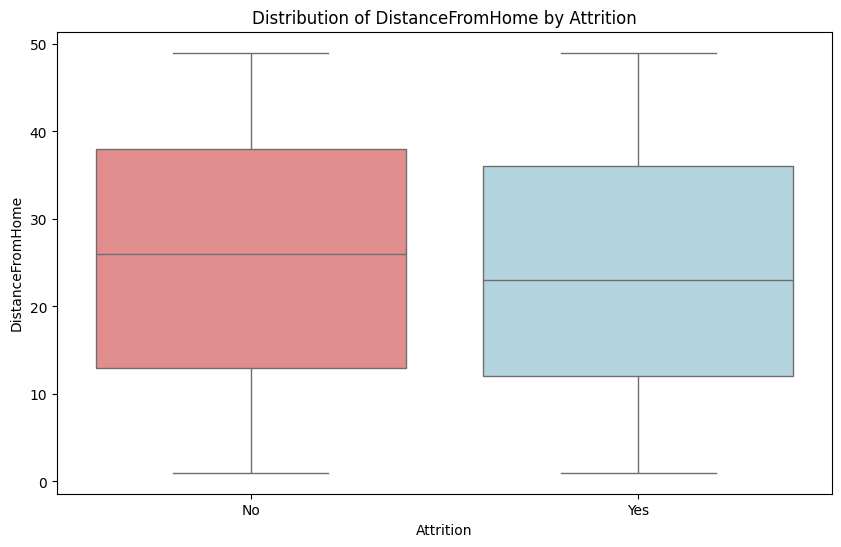

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/utils/visualisation.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numeric_feature, data=df, palette={'Yes': 'lightblue', 'No': 'lightcoral'})


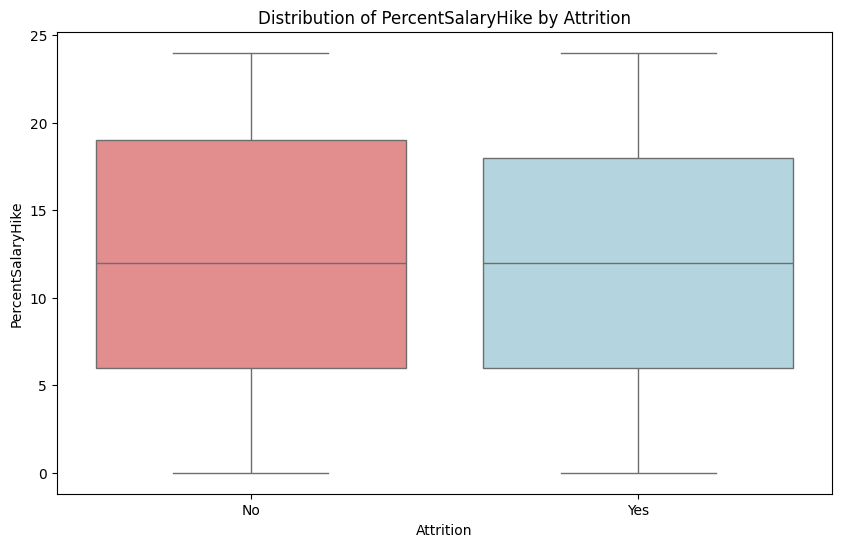

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/utils/visualisation.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numeric_feature, data=df, palette={'Yes': 'lightblue', 'No': 'lightcoral'})


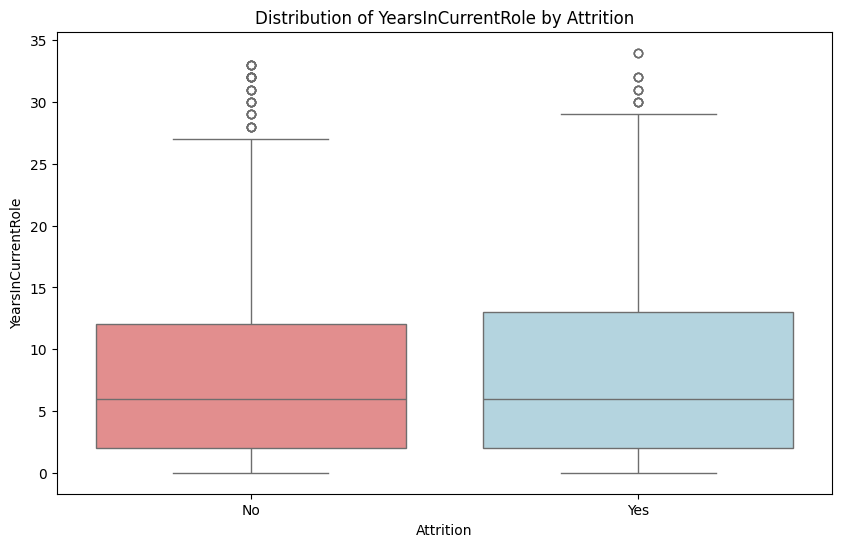

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/utils/visualisation.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numeric_feature, data=df, palette={'Yes': 'lightblue', 'No': 'lightcoral'})


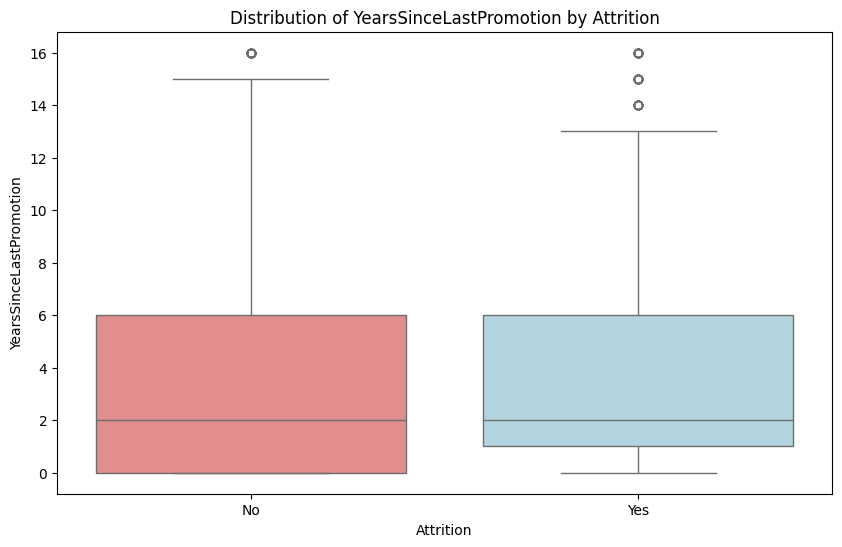

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/utils/visualisation.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numeric_feature, data=df, palette={'Yes': 'lightblue', 'No': 'lightcoral'})


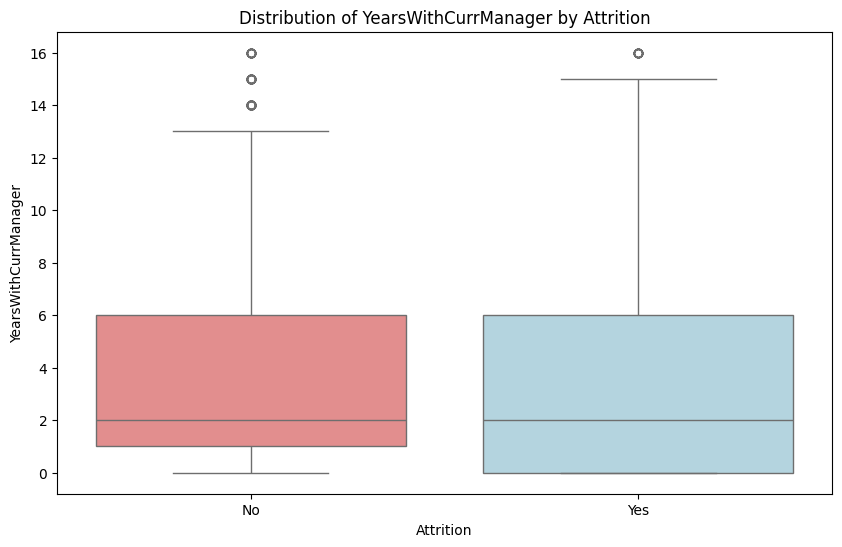

In [54]:

from utils.visualisation import plot_numeric_vs_target_boxplot


for feature in numeric_columns:
    plot_numeric_vs_target_boxplot(
        df_no_anomalies_cleaned_sanity,
        numeric_feature=feature, 
        target='Attrition'
    )
    


NameError: name 'df_num' is not defined

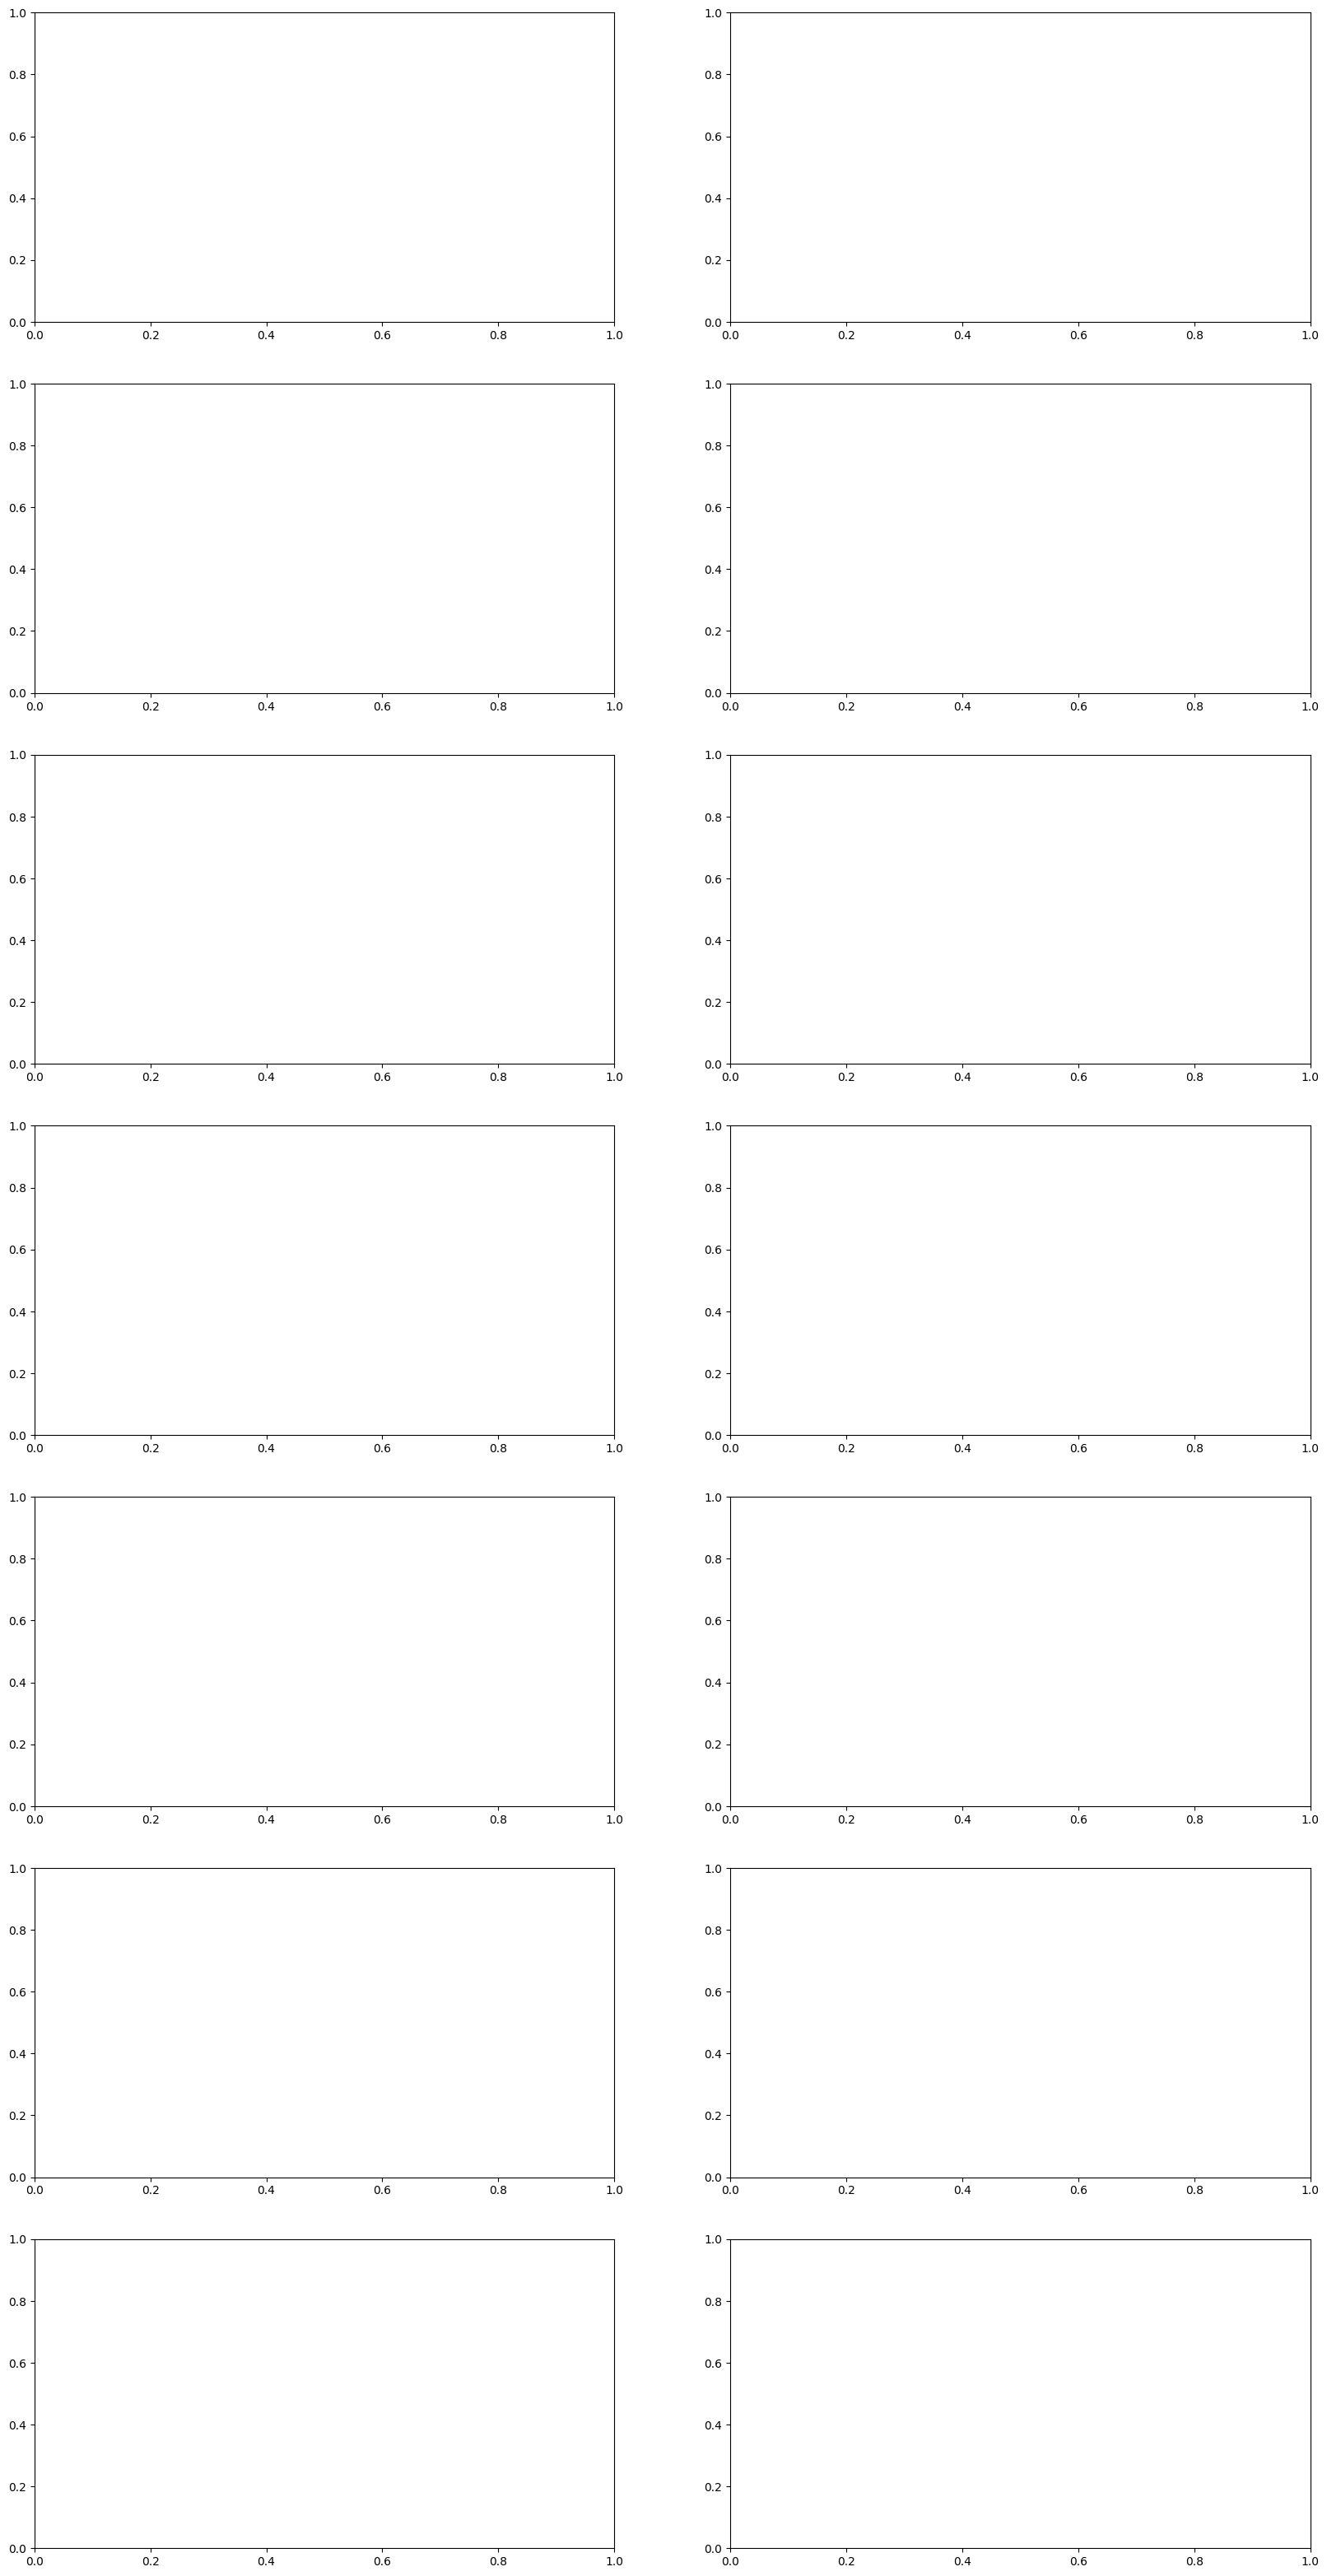

In [55]:
fig,subplots = plt.subplots(7,2,figsize=(20,40))
for col,axis in zip(df_num.columns,subplots.flatten()):
    plt.title(col)
    sns.boxplot(y=df_num[col],x=df["Attrition"],ax=axis)
plt.show()

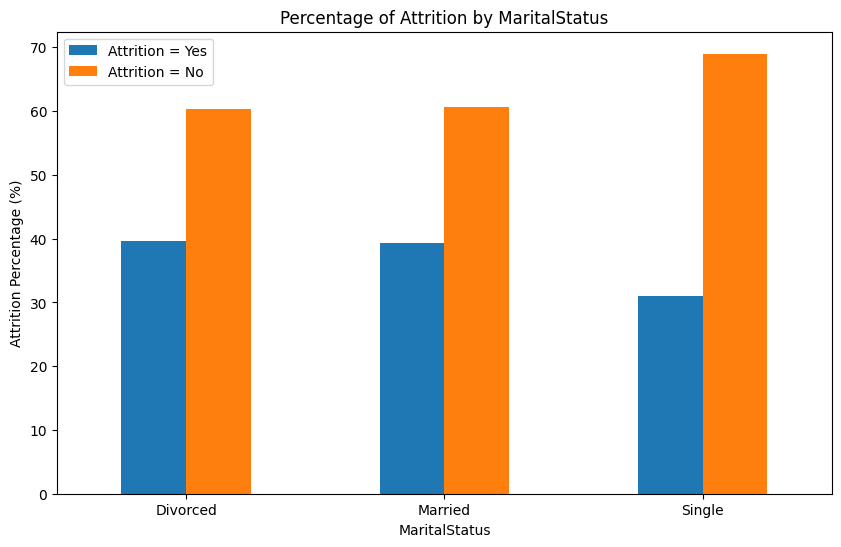

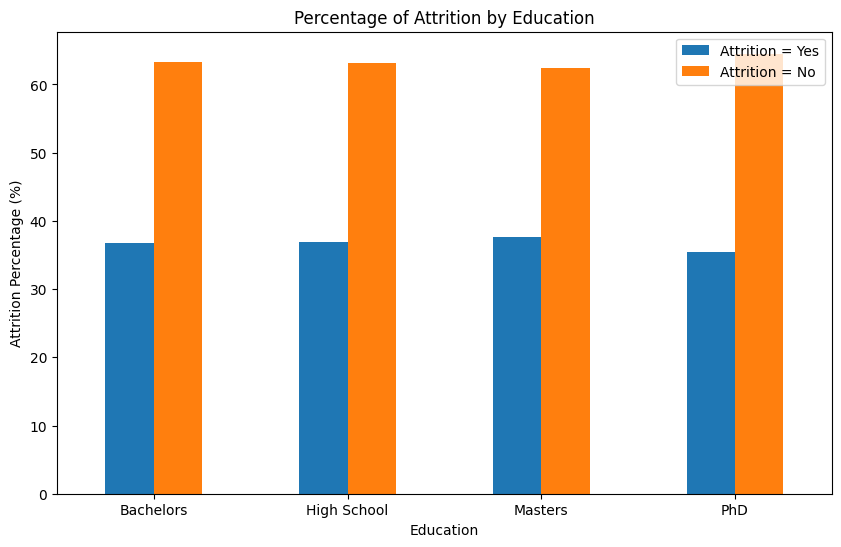

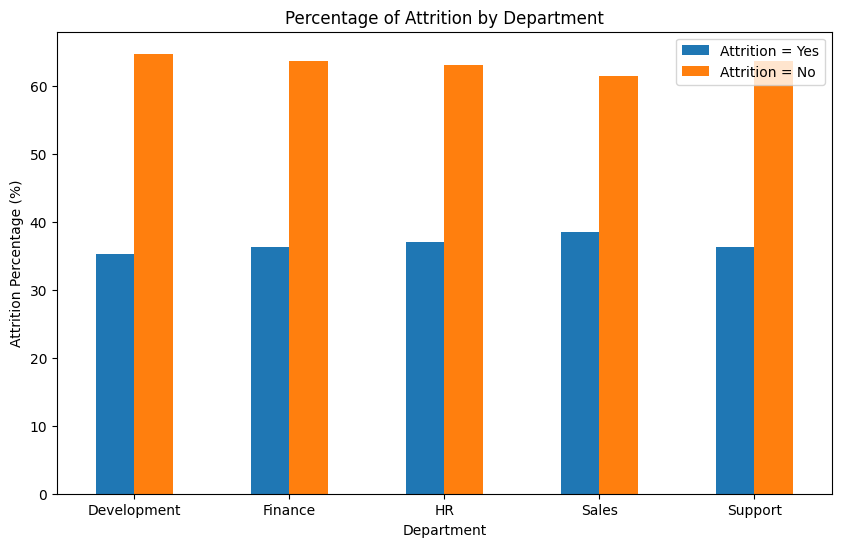

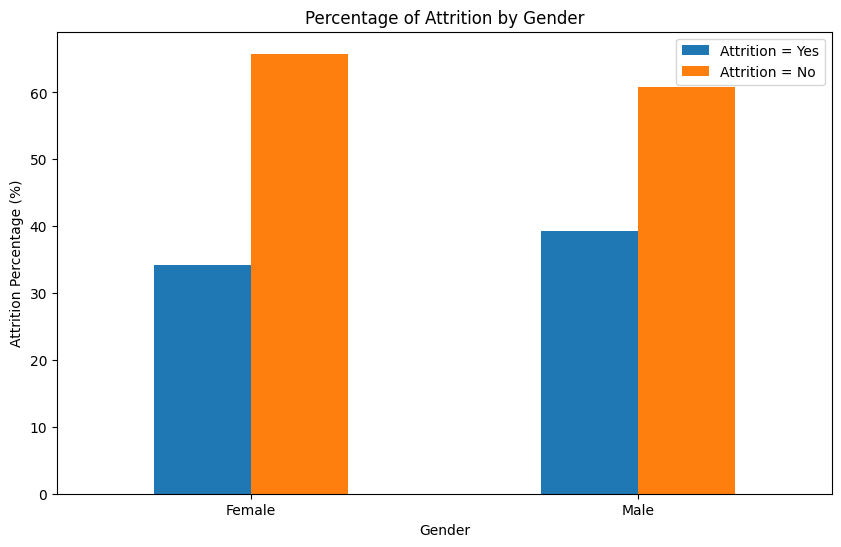

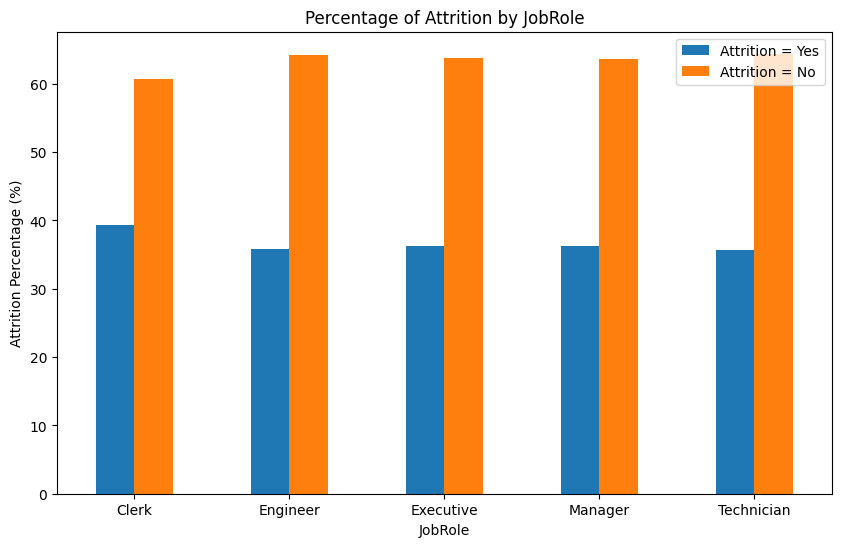

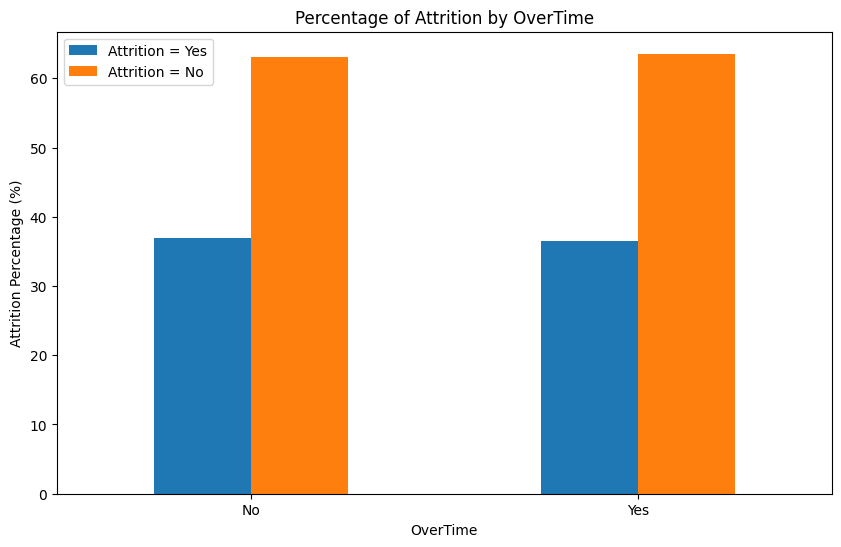

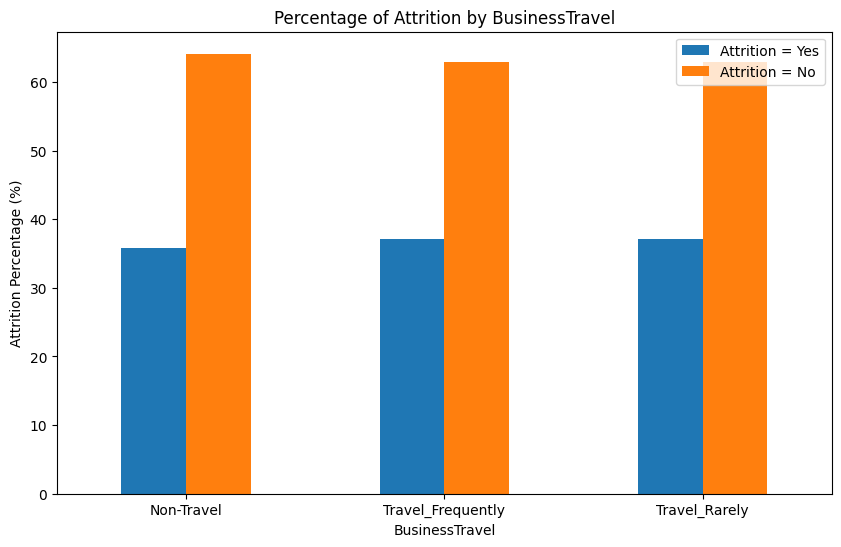

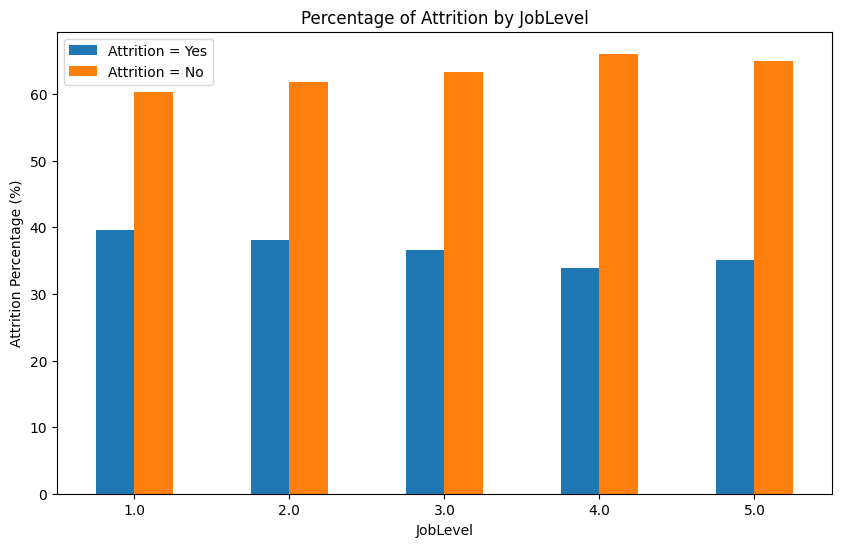

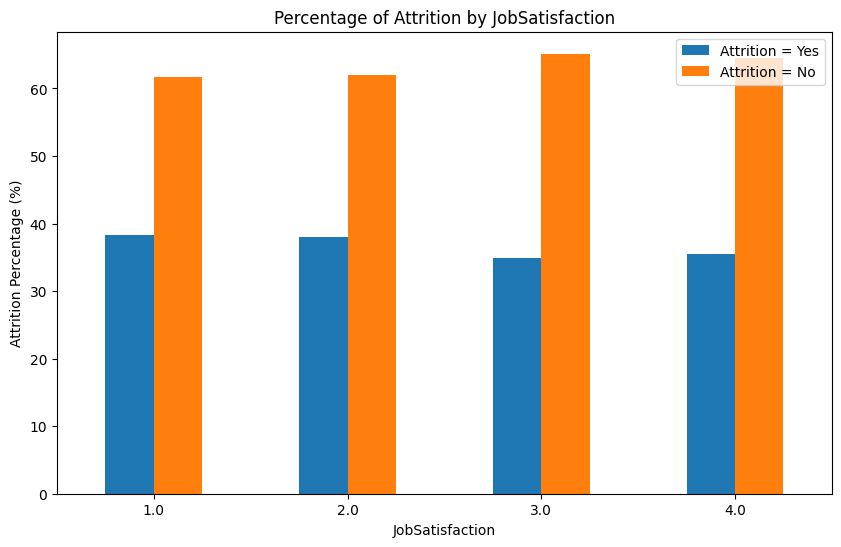

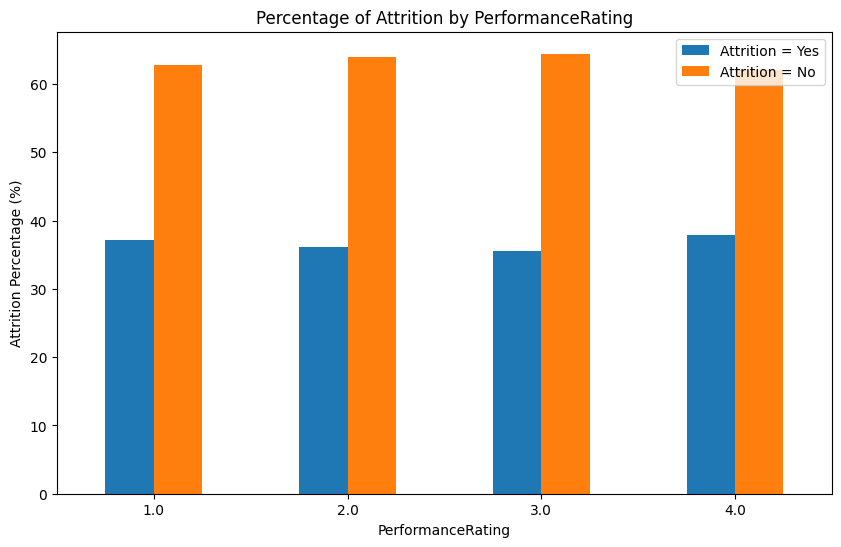

In [208]:
# List of categorical features
from utils.visualisation import plot_categorical_vs_target_grouped


categorical_features = [
    'MaritalStatus', 'Education', 'Department', 'Gender', 'JobRole', 'OverTime', 
    'BusinessTravel', 'JobLevel', 'JobSatisfaction', 'PerformanceRating'
]

# Assuming df is your DataFrame and 'Attrition' is the target variable
for feature in categorical_features:
    plot_categorical_vs_target_grouped(
        df_no_anomalies_cleaned_sanity,
        feature=feature, 
        target='Attrition'
    )

In [209]:
df_no_anomalies_cleaned_sanity[["JobRole", "JobLevel"]].value_counts()

JobRole     JobLevel
Clerk       3.0         203
            1.0         197
Manager     5.0         190
Clerk       2.0         188
            4.0         185
Executive   1.0         183
Technician  4.0         182
Engineer    3.0         181
Manager     1.0         178
Engineer    2.0         177
            5.0         175
Technician  3.0         174
Clerk       5.0         172
Engineer    1.0         170
Executive   2.0         168
Manager     4.0         167
Technician  2.0         167
            5.0         165
Manager     3.0         164
Technician  1.0         163
Manager     2.0         160
Executive   5.0         157
            4.0         155
            3.0         155
Engineer    4.0         151
Name: count, dtype: int64

## 3. Add Dummy Data

In [214]:
df_dummy_data = df_no_anomalies_cleaned_sanity.copy()
df_dummy_data.shape

(4327, 19)

In [215]:
from utils.feature_engineering import add_random_survey_fields


In [216]:
# Handle adding 2x dummy data columns
add_dummy_data = True

if add_dummy_data:
    df_dummy_data = add_random_survey_fields(df_dummy_data, seed_value=random_state_var)


df_dummy_data.head(2)

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,Attrition,WorkLifeBalanceScore_dummy,WorkPlaceSatisfactionScore_dummy,EmployeeEngagementLevel_dummy,TrainingOpportunitiesBool_dummy
0,56.0,9.0,19844.0,9.0,4.0,24.0,2.0,2.0,1.0,0.0,1.0,Male,Support,Masters,Married,Technician,No,Travel_Frequently,No,4,5,Medium,False
1,46.0,29.0,6687.0,39.0,1.0,20.0,1.0,14.0,11.0,7.0,1.0,Female,Sales,Bachelors,Single,Engineer,No,Non-Travel,No,5,3,Low,False


## 4. Feature Engineering

In [218]:
df_dummy_data.columns

Index(['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
       'JobLevel', 'PercentSalaryHike', 'PerformanceRating',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobSatisfaction', 'Gender', 'Department', 'Education', 'MaritalStatus',
       'JobRole', 'OverTime', 'BusinessTravel', 'Attrition',
       'WorkLifeBalanceScore_dummy', 'WorkPlaceSatisfactionScore_dummy',
       'EmployeeEngagementLevel_dummy', 'TrainingOpportunitiesBool_dummy'],
      dtype='object')

In [220]:
from utils.feature_engineering import apply_feature_engineering

df_w_features, additional_columns = apply_feature_engineering(
    df=df_dummy_data,
    add_dummy_data=True
)
print(f"Add new columns: {additional_columns}")
df_w_features.head()

Add new columns: ['SalaryHikeToJobLevel', 'DeptOvertimeRatio', 'IncomeToJobRoleAvg', 'IncomeToDeptAvg', 'MaritalGenderInteraction', 'PromotionToCompanyRatio', 'RoleToCompanyRatio', 'OvertimeJobSatisfactionInteraction', 'AgeGroup', 'DistanceGroup', 'YearsAtCompanyPerformanceInteraction']


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,Attrition,WorkLifeBalanceScore_dummy,WorkPlaceSatisfactionScore_dummy,EmployeeEngagementLevel_dummy,TrainingOpportunitiesBool_dummy,RoleToCompanyRatio,PromotionToCompanyRatio,SalaryHikeToJobLevel,IncomeToDeptAvg,IncomeToJobRoleAvg,DeptOvertimeRatio,DistanceGroup,AgeGroup,MaritalGenderInteraction,OvertimeJobSatisfactionInteraction,YearsAtCompanyPerformanceInteraction
0,56.0,9.0,19844.0,9.0,4.0,24.0,2.0,2.0,1.0,0.0,1.0,Male,Support,Masters,Married,Technician,No,Travel_Frequently,No,4,5,Medium,False,0.222222,0.111111,6.0,1.803461,1.759983,0.486797,Close,50+,Married_Male,No_1.0,18.0
1,46.0,29.0,6687.0,39.0,1.0,20.0,1.0,14.0,11.0,7.0,1.0,Female,Sales,Bachelors,Single,Engineer,No,Non-Travel,No,5,3,Low,False,0.482759,0.379310,20.0,0.603178,0.592464,0.483835,Very Far,40-50,Single_Female,No_1.0,29.0
2,32.0,35.0,7357.0,1.0,1.0,12.0,1.0,11.0,7.0,0.0,4.0,Male,HR,PhD,Single,Clerk,No,Non-Travel,Yes,3,3,Low,False,0.314286,0.200000,12.0,0.658943,0.676739,0.474654,Close,30-40,Single_Male,No_4.0,35.0
3,60.0,39.0,2327.0,33.0,1.0,0.0,2.0,12.0,6.0,5.0,3.0,Male,Support,PhD,Single,Technician,Yes,Travel_Rarely,Yes,5,4,High,True,0.307692,0.153846,0.0,0.211482,0.206384,0.486797,Far,50+,Single_Male,Yes_3.0,78.0
4,25.0,14.0,12285.0,38.0,5.0,24.0,3.0,9.0,4.0,9.0,3.0,Male,Support,High School,Single,Executive,Yes,Travel_Rarely,Yes,5,5,Medium,False,0.642857,0.285714,4.8,1.116485,1.128601,0.486797,Very Far,Under 30,Single_Male,Yes_3.0,42.0


In [221]:
df_w_features.columns

Index(['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
       'JobLevel', 'PercentSalaryHike', 'PerformanceRating',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobSatisfaction', 'Gender', 'Department', 'Education', 'MaritalStatus',
       'JobRole', 'OverTime', 'BusinessTravel', 'Attrition',
       'WorkLifeBalanceScore_dummy', 'WorkPlaceSatisfactionScore_dummy',
       'EmployeeEngagementLevel_dummy', 'TrainingOpportunitiesBool_dummy',
       'RoleToCompanyRatio', 'PromotionToCompanyRatio', 'SalaryHikeToJobLevel',
       'IncomeToDeptAvg', 'IncomeToJobRoleAvg', 'DeptOvertimeRatio',
       'DistanceGroup', 'AgeGroup', 'MaritalGenderInteraction',
       'OvertimeJobSatisfactionInteraction',
       'YearsAtCompanyPerformanceInteraction'],
      dtype='object')

In [222]:
df_w_features.isna().sum()

Age                                     0
YearsAtCompany                          0
MonthlyIncome                           0
DistanceFromHome                        0
JobLevel                                0
PercentSalaryHike                       0
PerformanceRating                       0
YearsInCurrentRole                      0
YearsSinceLastPromotion                 0
YearsWithCurrManager                    0
JobSatisfaction                         0
Gender                                  0
Department                              0
Education                               0
MaritalStatus                           0
JobRole                                 0
OverTime                                0
BusinessTravel                          0
Attrition                               0
WorkLifeBalanceScore_dummy              0
WorkPlaceSatisfactionScore_dummy        0
EmployeeEngagementLevel_dummy           0
TrainingOpportunitiesBool_dummy         0
RoleToCompanyRatio                

## 5. Create Numeric target Variable

In [225]:
target_class_str_mapper = {
    "No": 0,
    "Yes": 1,
}
target_class_str = "Attrition"
target_class = "target"
df_w_features[target_class] = df_w_features[target_class_str].apply(lambda x: target_class_str_mapper[x])
df_w_features = df_w_features.drop(columns=["Attrition"])
df_w_features[target_class].value_counts()

target
0    2739
1    1588
Name: count, dtype: int64

In [226]:
df_w_features.columns

Index(['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
       'JobLevel', 'PercentSalaryHike', 'PerformanceRating',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobSatisfaction', 'Gender', 'Department', 'Education', 'MaritalStatus',
       'JobRole', 'OverTime', 'BusinessTravel', 'WorkLifeBalanceScore_dummy',
       'WorkPlaceSatisfactionScore_dummy', 'EmployeeEngagementLevel_dummy',
       'TrainingOpportunitiesBool_dummy', 'RoleToCompanyRatio',
       'PromotionToCompanyRatio', 'SalaryHikeToJobLevel', 'IncomeToDeptAvg',
       'IncomeToJobRoleAvg', 'DeptOvertimeRatio', 'DistanceGroup', 'AgeGroup',
       'MaritalGenderInteraction', 'OvertimeJobSatisfactionInteraction',
       'YearsAtCompanyPerformanceInteraction', 'target'],
      dtype='object')

In [229]:
cols_to_select = list(df_w_features.iloc[:, :18].columns) + [target_class]
cols_to_select

['Age',
 'YearsAtCompany',
 'MonthlyIncome',
 'DistanceFromHome',
 'JobLevel',
 'PercentSalaryHike',
 'PerformanceRating',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'JobSatisfaction',
 'Gender',
 'Department',
 'Education',
 'MaritalStatus',
 'JobRole',
 'OverTime',
 'BusinessTravel',
 'target']

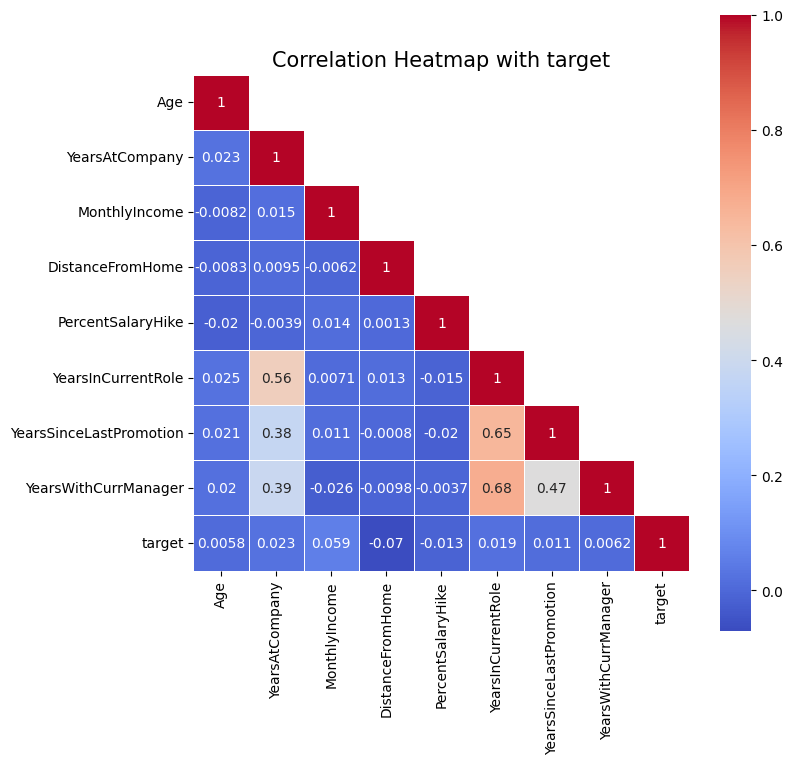

In [230]:
from utils.visualisation import plot_correlation_matrix_with_target


# Plot heatmaps showing correlation between each feature and Attrition
plot_correlation_matrix_with_target(
    df=df_w_features[cols_to_select], 
    # df=df_w_features[cols_to_select].drop(columns="Attrition", errors="ignore"), 
    target_column='target',
)

## ANOVA test for correlation between target and numerical features

In [246]:
df_anova = df_w_features[cols_to_select]
df_anova.head()

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,target
0,56.0,9.0,19844.0,9.0,4.0,24.0,2.0,2.0,1.0,0.0,1.0,Male,Support,Masters,Married,Technician,No,Travel_Frequently,0
1,46.0,29.0,6687.0,39.0,1.0,20.0,1.0,14.0,11.0,7.0,1.0,Female,Sales,Bachelors,Single,Engineer,No,Non-Travel,0
2,32.0,35.0,7357.0,1.0,1.0,12.0,1.0,11.0,7.0,0.0,4.0,Male,HR,PhD,Single,Clerk,No,Non-Travel,1
3,60.0,39.0,2327.0,33.0,1.0,0.0,2.0,12.0,6.0,5.0,3.0,Male,Support,PhD,Single,Technician,Yes,Travel_Rarely,1
4,25.0,14.0,12285.0,38.0,5.0,24.0,3.0,9.0,4.0,9.0,3.0,Male,Support,High School,Single,Executive,Yes,Travel_Rarely,1


In [251]:
from utils.stats import run_statistical_tests


run_statistical_tests(df_anova, target="target")

ANOVA Test (Numeric Features):
P-value for correlation between target and Age: 0.7013
P-value for correlation between target and YearsAtCompany: 0.1315
P-value for correlation between target and MonthlyIncome: 0.0001
P-value for correlation between target and DistanceFromHome: 0.0
P-value for correlation between target and PercentSalaryHike: 0.4055
P-value for correlation between target and YearsInCurrentRole: 0.2162
P-value for correlation between target and YearsSinceLastPromotion: 0.469
P-value for correlation between target and YearsWithCurrManager: 0.6823

Chi-Square Test (Categorical Features):
P-value for association between target and Gender: 0.0006
P-value for association between target and Department: 0.6871
P-value for association between target and Education: 0.7738
P-value for association between target and MaritalStatus: 0.0
P-value for association between target and JobRole: 0.4738
P-value for association between target and OverTime: 0.7668
P-value for association betwee

### Save data out

In [235]:
# Save raw un scaled and non-one-hot encoded data
cleaned_raw_fname = os.path.join(transformed_data_dir, "cleaned_non_scaled_non_one_hot_data_17_09_2024.csv")
df_w_features.to_csv(cleaned_raw_fname, index=False)

In [236]:
df_w_features

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Gender,Department,Education,MaritalStatus,JobRole,OverTime,BusinessTravel,WorkLifeBalanceScore_dummy,WorkPlaceSatisfactionScore_dummy,EmployeeEngagementLevel_dummy,TrainingOpportunitiesBool_dummy,RoleToCompanyRatio,PromotionToCompanyRatio,SalaryHikeToJobLevel,IncomeToDeptAvg,IncomeToJobRoleAvg,DeptOvertimeRatio,DistanceGroup,AgeGroup,MaritalGenderInteraction,OvertimeJobSatisfactionInteraction,YearsAtCompanyPerformanceInteraction,target
0,56.0,9.0,19844.0,9.0,4.0,24.0,2.0,2.0,1.0,0.0,1.0,Male,Support,Masters,Married,Technician,No,Travel_Frequently,4,5,Medium,False,0.222222,0.111111,6.0,1.803461,1.759983,0.486797,Close,50+,Married_Male,No_1.0,18.0,0
1,46.0,29.0,6687.0,39.0,1.0,20.0,1.0,14.0,11.0,7.0,1.0,Female,Sales,Bachelors,Single,Engineer,No,Non-Travel,5,3,Low,False,0.482759,0.379310,20.0,0.603178,0.592464,0.483835,Very Far,40-50,Single_Female,No_1.0,29.0,0
2,32.0,35.0,7357.0,1.0,1.0,12.0,1.0,11.0,7.0,0.0,4.0,Male,HR,PhD,Single,Clerk,No,Non-Travel,3,3,Low,False,0.314286,0.200000,12.0,0.658943,0.676739,0.474654,Close,30-40,Single_Male,No_4.0,35.0,1
3,60.0,39.0,2327.0,33.0,1.0,0.0,2.0,12.0,6.0,5.0,3.0,Male,Support,PhD,Single,Technician,Yes,Travel_Rarely,5,4,High,True,0.307692,0.153846,0.0,0.211482,0.206384,0.486797,Far,50+,Single_Male,Yes_3.0,78.0,1
4,25.0,14.0,12285.0,38.0,5.0,24.0,3.0,9.0,4.0,9.0,3.0,Male,Support,High School,Single,Executive,Yes,Travel_Rarely,5,5,Medium,False,0.642857,0.285714,4.8,1.116485,1.128601,0.486797,Very Far,Under 30,Single_Male,Yes_3.0,42.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,20.0,35.0,19280.0,34.0,5.0,19.0,2.0,1.0,1.0,1.0,3.0,Male,HR,PhD,Divorced,Manager,No,Travel_Frequently,1,5,Medium,False,0.028571,0.028571,3.8,1.726848,1.726901,0.474654,Far,Under 30,Divorced_Male,No_3.0,70.0,0
4995,33.0,6.0,8345.0,23.0,1.0,14.0,3.0,1.0,0.0,1.0,2.0,Female,HR,Masters,Married,Executive,Yes,Travel_Frequently,3,1,High,False,0.166667,0.000000,14.0,0.747435,0.766640,0.474654,Moderate,30-40,Married_Female,Yes_2.0,18.0,0
4996,22.0,22.0,15322.0,49.0,2.0,24.0,2.0,5.0,1.0,3.0,4.0,Male,Finance,Bachelors,Single,Technician,No,Travel_Frequently,4,3,Low,True,0.227273,0.045455,12.0,1.367007,1.358923,0.506418,Very Far,Under 30,Single_Male,No_4.0,44.0,1
4998,27.0,31.0,18398.0,19.0,5.0,15.0,4.0,29.0,4.0,12.0,2.0,Female,Finance,High School,Married,Technician,Yes,Non-Travel,3,2,High,True,0.935484,0.129032,3.0,1.641443,1.631736,0.506418,Moderate,Under 30,Married_Female,Yes_2.0,124.0,1


In [ ]:
assert False

## 3. Encoding Categorical Variables

In [231]:
categorical_columns = df_w_features.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['JobLevel',
 'PerformanceRating',
 'JobSatisfaction',
 'Gender',
 'Department',
 'Education',
 'MaritalStatus',
 'JobRole',
 'OverTime',
 'BusinessTravel',
 'EmployeeEngagementLevel_dummy',
 'DistanceGroup',
 'AgeGroup',
 'MaritalGenderInteraction',
 'OvertimeJobSatisfactionInteraction']

In [234]:
df_transformed = df_w_features.copy()
df_transformed.shape

(4327, 34)

# STOP - HERE DO ALL OF THIS IN TRAINING

In [114]:

def one_hot_encode_selected_columns(df, columns_to_encode):
    """
    One-hot encodes the specified object columns and saves the mappings of original columns to the new one-hot encoded columns.
    Returns the transformed dataframe and a dictionary of mappings.
    """
    one_hot_mappings = {}
    
    # Iterate through the specified columns
    for column in columns_to_encode:
        # Perform one-hot encoding on the column
        dummies = pd.get_dummies(df[column], prefix=column)
        # Save the mapping of original column to one-hot encoded columns
        one_hot_mappings[column] = dummies.columns.tolist()
        # Drop the original column and concatenate the one-hot encoded columns
        df = df.drop(column, axis=1)
        df = pd.concat([df, dummies], axis=1)
    
    return df, one_hot_mappings


In [112]:
categorical_columns.remove("Attrition")
categorical_columns

['Gender',
 'Department',
 'Education',
 'MaritalStatus',
 'JobRole',
 'OverTime',
 'BusinessTravel',
 'JobLevel',
 'PerformanceRating',
 'JobSatisfaction',
 'EmployeeEngagementLevel_dummy',
 'DistanceGroup',
 'AgeGroup',
 'MaritalGenderInteraction',
 'OvertimeJobSatisfactionInteraction']

In [115]:
assert "Attrition" not in categorical_columns

df_one_hot, one_hot_mappings = one_hot_encode_selected_columns(df=df_transformed, columns_to_encode=categorical_columns)

print(df_one_hot.shape)
df_one_hot.head()

(4310, 80)


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,PercentSalaryHike,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,WorkLifeBalanceScore_dummy,RoleToCompanyRatio,PromotionToCompanyRatio,SalaryHikeToJobLevel,IncomeToDeptAvg,IncomeToJobRoleAvg,DeptOvertimeRatio,YearsAtCompanyPerformanceInteraction,target,Gender_Female,Gender_Male,Department_Development,Department_Finance,Department_HR,Department_Sales,Department_Support,Education_Bachelors,Education_High School,Education_Masters,Education_PhD,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,JobRole_Clerk,JobRole_Engineer,JobRole_Executive,JobRole_Manager,JobRole_Technician,OverTime_No,OverTime_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,JobLevel_1.0,JobLevel_2.0,JobLevel_3.0,JobLevel_4.0,JobLevel_5.0,PerformanceRating_1.0,PerformanceRating_2.0,PerformanceRating_3.0,PerformanceRating_4.0,JobSatisfaction_1.0,JobSatisfaction_2.0,JobSatisfaction_3.0,JobSatisfaction_4.0,EmployeeEngagementLevel_dummy_High,EmployeeEngagementLevel_dummy_Low,EmployeeEngagementLevel_dummy_Medium,DistanceGroup_Close,DistanceGroup_Moderate,DistanceGroup_Far,DistanceGroup_Very Far,AgeGroup_Under 30,AgeGroup_30-40,AgeGroup_40-50,AgeGroup_50+,MaritalGenderInteraction_Divorced_Female,MaritalGenderInteraction_Divorced_Male,MaritalGenderInteraction_Married_Female,MaritalGenderInteraction_Married_Male,MaritalGenderInteraction_Single_Female,MaritalGenderInteraction_Single_Male,OvertimeJobSatisfactionInteraction_No_1.0,OvertimeJobSatisfactionInteraction_No_2.0,OvertimeJobSatisfactionInteraction_No_3.0,OvertimeJobSatisfactionInteraction_No_4.0,OvertimeJobSatisfactionInteraction_Yes_1.0,OvertimeJobSatisfactionInteraction_Yes_2.0,OvertimeJobSatisfactionInteraction_Yes_3.0,OvertimeJobSatisfactionInteraction_Yes_4.0
0,56.0,9.0,19844.0,9.0,24.0,2.0,1.0,0.0,No,4.0,0.222222,0.111111,6.0,1.804546,1.760652,0.486766,18.0,0,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False
1,46.0,29.0,6687.0,39.0,20.0,14.0,11.0,7.0,No,5.0,0.482759,0.379310,20.0,0.603303,0.593617,0.484305,29.0,0,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False
2,32.0,35.0,7357.0,1.0,12.0,11.0,7.0,0.0,Yes,3.0,0.314286,0.200000,12.0,0.659691,0.677964,0.475145,35.0,1,False,True,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
3,60.0,39.0,2327.0,33.0,0.0,12.0,6.0,5.0,Yes,5.0,0.307692,0.153846,0.0,0.211609,0.206462,0.486766,78.0,1,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
4,25.0,14.0,12285.0,38.0,24.0,9.0,4.0,9.0,Yes,5.0,0.642857,0.285714,4.8,1.117156,1.128601,0.486766,42.0,1,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,

In [116]:
one_hot_mappings

{'Gender': ['Gender_Female', 'Gender_Male'],
 'Department': ['Department_Development',
  'Department_Finance',
  'Department_HR',
  'Department_Sales',
  'Department_Support'],
 'Education': ['Education_Bachelors',
  'Education_High School',
  'Education_Masters',
  'Education_PhD'],
 'MaritalStatus': ['MaritalStatus_Divorced',
  'MaritalStatus_Married',
  'MaritalStatus_Single'],
 'JobRole': ['JobRole_Clerk',
  'JobRole_Engineer',
  'JobRole_Executive',
  'JobRole_Manager',
  'JobRole_Technician'],
 'OverTime': ['OverTime_No', 'OverTime_Yes'],
 'BusinessTravel': ['BusinessTravel_Non-Travel',
  'BusinessTravel_Travel_Frequently',
  'BusinessTravel_Travel_Rarely'],
 'JobLevel': ['JobLevel_1.0',
  'JobLevel_2.0',
  'JobLevel_3.0',
  'JobLevel_4.0',
  'JobLevel_5.0'],
 'PerformanceRating': ['PerformanceRating_1.0',
  'PerformanceRating_2.0',
  'PerformanceRating_3.0',
  'PerformanceRating_4.0'],
 'JobSatisfaction': ['JobSatisfaction_1.0',
  'JobSatisfaction_2.0',
  'JobSatisfaction_3.0',


In [117]:
# Save raw un scaled and non-one-hot encoded data
cleaned_raw_non_scaled_fname = os.path.join(transformed_data_dir, "cleaned_non_scaled_17_09_2024.csv")
df_one_hot.to_csv(cleaned_raw_non_scaled_fname, index=False)

In [118]:
integer_columns = df_one_hot.select_dtypes(include=['int', 'float']).columns.tolist()
integer_columns.remove("target")

integer_columns

['Age',
 'YearsAtCompany',
 'MonthlyIncome',
 'DistanceFromHome',
 'PercentSalaryHike',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'WorkLifeBalanceScore_dummy',
 'RoleToCompanyRatio',
 'PromotionToCompanyRatio',
 'SalaryHikeToJobLevel',
 'IncomeToDeptAvg',
 'IncomeToJobRoleAvg',
 'DeptOvertimeRatio',
 'YearsAtCompanyPerformanceInteraction']

In [119]:
from typing import List
from sklearn.preprocessing import StandardScaler
import pandas as pd

def scale_numeric_features(df: pd.DataFrame, numeric_columns: List[str]) -> tuple:
    """
    This function scales the numeric features in the dataframe excluding the target column.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - target_column (str): The name of the target column to exclude from scaling.

    Returns:
    - df_scaled (pd.DataFrame): The dataframe with scaled numeric features.
    - scaler (StandardScaler): The fitted scaler used for scaling.
    """    
    # Copy the dataframe to avoid altering the original one
    df_scaled = df.copy()
    
    # Initialize and fit the scaler
    scaler = StandardScaler()
    df_scaled[numeric_columns] = scaler.fit_transform(df_scaled[numeric_columns])
    
    return df_scaled, scaler


def reverse_scaling(df_scaled: pd.DataFrame, scaler: StandardScaler, numeric_columns: List[str]) -> pd.DataFrame:
    """
    This function reverses the scaling and returns the dataframe to its original state.
    
    Parameters:
    - df_scaled (pd.DataFrame): The scaled dataframe.
    - scaler (StandardScaler): The fitted scaler used for scaling.
    - original_df (pd.DataFrame): The original dataframe (used for reference to check column types).
    - target_column (str): The name of the target column to exclude from the reverse scaling.
    
    Returns:
    - df_reversed (pd.DataFrame): The dataframe with reversed scaling.
    """
    
    # Copy the scaled dataframe to avoid altering it
    df_reversed = df_scaled.copy()
    
    # Apply inverse transformation to the scaled numeric columns
    df_reversed[numeric_columns] = scaler.inverse_transform(df_scaled[numeric_columns])
    
    return df_reversed


In [120]:
# Scale numeric features (excluding target column 'Attrition')
df_scaled = df_one_hot.copy()

# Identify numeric columns (excluding the target column)
numeric_columns = df_scaled.select_dtypes(include=[np.number]).columns
numeric_columns = numeric_columns.drop(target_class)
print("numeric_columns: \n", list(numeric_columns))
df_scaled, fitted_scaler = scale_numeric_features(df_scaled, numeric_columns=numeric_columns)

print("Scaled DataFrame:")
df_scaled.head()

numeric_columns: 
 ['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome', 'PercentSalaryHike', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'WorkLifeBalanceScore_dummy', 'RoleToCompanyRatio', 'PromotionToCompanyRatio', 'SalaryHikeToJobLevel', 'IncomeToDeptAvg', 'IncomeToJobRoleAvg', 'DeptOvertimeRatio', 'YearsAtCompanyPerformanceInteraction']
Scaled DataFrame:


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,PercentSalaryHike,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,WorkLifeBalanceScore_dummy,RoleToCompanyRatio,PromotionToCompanyRatio,SalaryHikeToJobLevel,IncomeToDeptAvg,IncomeToJobRoleAvg,DeptOvertimeRatio,YearsAtCompanyPerformanceInteraction,target,Gender_Female,Gender_Male,Department_Development,Department_Finance,Department_HR,Department_Sales,Department_Support,Education_Bachelors,Education_High School,Education_Masters,Education_PhD,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,JobRole_Clerk,JobRole_Engineer,JobRole_Executive,JobRole_Manager,JobRole_Technician,OverTime_No,OverTime_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,JobLevel_1.0,JobLevel_2.0,JobLevel_3.0,JobLevel_4.0,JobLevel_5.0,PerformanceRating_1.0,PerformanceRating_2.0,PerformanceRating_3.0,PerformanceRating_4.0,JobSatisfaction_1.0,JobSatisfaction_2.0,JobSatisfaction_3.0,JobSatisfaction_4.0,EmployeeEngagementLevel_dummy_High,EmployeeEngagementLevel_dummy_Low,EmployeeEngagementLevel_dummy_Medium,DistanceGroup_Close,DistanceGroup_Moderate,DistanceGroup_Far,DistanceGroup_Very Far,AgeGroup_Under 30,AgeGroup_30-40,AgeGroup_40-50,AgeGroup_50+,MaritalGenderInteraction_Divorced_Female,MaritalGenderInteraction_Divorced_Male,MaritalGenderInteraction_Married_Female,MaritalGenderInteraction_Married_Male,MaritalGenderInteraction_Single_Female,MaritalGenderInteraction_Single_Male,OvertimeJobSatisfactionInteraction_No_1.0,OvertimeJobSatisfactionInteraction_No_2.0,OvertimeJobSatisfactionInteraction_No_3.0,OvertimeJobSatisfactionInteraction_No_4.0,OvertimeJobSatisfactionInteraction_Yes_1.0,OvertimeJobSatisfactionInteraction_Yes_2.0,OvertimeJobSatisfactionInteraction_Yes_3.0,OvertimeJobSatisfactionInteraction_Yes_4.0
0,1.094496,-0.882370,1.696610,-1.118965,1.645309,-0.866686,-0.667242,-0.927282,No,0.696054,-0.784017,-0.461042,0.084202,1.727386,1.633195,-0.196852,-0.787480,0,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False
1,0.356141,0.940307,-0.851763,1.000423,1.096108,0.820303,1.847459,0.825716,No,1.396495,0.051465,0.713842,2.704706,-0.851721,-0.872545,-0.427950,-0.484414,0,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False
2,-0.677557,1.487110,-0.721991,-1.684135,-0.002294,0.398556,0.841578,-0.927282,Yes,-0.004388,-0.488790,-0.071652,1.207275,-0.730655,-0.691444,-1.287988,-0.319105,1,False,True,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
3,1.389839,1.851646,-1.696249,0.576546,-1.649896,0.539138,0.590108,0.324860,Yes,1.396495,-0.509933,-0.273835,-1.038871,-1.692701,-1.703805,-0.196852,0.865608,1,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
4,-1.194406,-0.426701,0.232511,0.929777,1.645309,0.117391,0.087168,1.326573,Yes,1.396495

In [94]:
# Log the scaler model with MLFlow
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="StandardScaler_Scaling"
):
    mlflow.sklearn.log_model(fitted_scaler, "scaler_model")
    mlflow.log_param("scaled_columns", numeric_columns.tolist())
    mlflow.log_metric("num_columns_scaled", len(numeric_columns))


2024/09/17 18:41:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/09/17 18:41:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [281]:
# # Reverse the scaling back to original values
# # Identify numeric columns (excluding the target column)
# df_reversed = reverse_scaling(
#     df_scaled=df_scaled, 
#     scaler=fitted_scaler, 
#     numeric_columns=numeric_columns, 
# )

# print("Reversed DataFrame:")
# df_reversed.head()

Reversed DataFrame:


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,PercentSalaryHike,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,WorkLifeBalanceScore_dummy,RoleToCompanyRatio,...,MaritalGenderInteraction_Single_Female,MaritalGenderInteraction_Single_Male,OvertimeJobSatisfactionInteraction_No_1.0,OvertimeJobSatisfactionInteraction_No_2.0,OvertimeJobSatisfactionInteraction_No_3.0,OvertimeJobSatisfactionInteraction_No_4.0,OvertimeJobSatisfactionInteraction_Yes_1.0,OvertimeJobSatisfactionInteraction_Yes_2.0,OvertimeJobSatisfactionInteraction_Yes_3.0,OvertimeJobSatisfactionInteraction_Yes_4.0
0,56.0,9.0,19844.0,9.0,24.0,2.0,1.0,0.0,4.0,0.222222,...,False,False,True,False,False,False,False,False,False,False
1,46.0,29.0,6687.0,39.0,20.0,14.0,11.0,7.0,5.0,0.482759,...,True,False,True,False,False,False,False,False,False,False
2,32.0,35.0,7357.0,1.0,12.0,11.0,7.0,0.0,3.0,0.314286,...,False,True,False,False,False,True,False,False,False,False
3,60.0,39.0,2327.0,33.0,0.0,12.0,6.0,5.0,5.0,0.307692,...,False,True,False,False,False,False,False,False,True,False
4,25.0,14.0,12285.0,38.0,24.0,9.0,4.0,9.0,5.0,0.642857,...,False,True,False,False,False,False,False,False,True,False


In [121]:
df_scaled[integer_columns].describe()

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,PercentSalaryHike,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,WorkLifeBalanceScore_dummy,RoleToCompanyRatio,PromotionToCompanyRatio,SalaryHikeToJobLevel,IncomeToDeptAvg,IncomeToJobRoleAvg,DeptOvertimeRatio,YearsAtCompanyPerformanceInteraction
count,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03,4.310000e+03
mean,1.236443e-17,-4.739699e-17,-1.195228e-16,5.852498e-17,-7.913237e-17,9.685472e-17,4.945773e-17,-2.143168e-17,-7.418660e-18,2.802605e-17,-1.483732e-17,-1.384816e-16,4.409981e-17,5.728854e-17,1.371628e-15,2.967464e-17
std,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00
min,-2.523446e+00,-1.611441e+00,-1.759585e+00,-1.684135e+00,-1.649896e+00,-1.147851e+00,-9.187115e-01,-9.272823e-01,-1.405271e+00,-1.496633e+00,-9.477797e-01,-1.038871e+00,-1.761991e+00,-1.763991e+00,-1.287988e+00,-1.255855e+00
25%,-8.252280e-01,-8.823705e-01,-8.592199e-01,-8.363798e-01,-8.260950e-01,-8.666857e-01,-9.187115e-01,-6.768539e-01,-7.048295e-01,-8.552784e-01,-9.477797e-01,-6.645130e-01,-8.603763e-01,-8.607028e-01,-4.279499e-01,-7.874798e-01
50%,-1.303686e-02,-6.216557e-02,1.848395e-02,1.137553e-02,-2.293647e-03,-3.043560e-01,-4.157715e-01,-4.264255e-01,-4.387917e-03,-5.911375e-02,-2.906838e-01,-2.901554e-01,2.271188e-02,1.849352e-02,-1.968523e-01,-2.915533e-01
75%,8.729898e-01,8.491732e-01,8.584184e-01,8.591309e-01,8.215077e-01,5.391385e-01,5.901085e-01,5.752881e-01,6.960537e-01,7.939198e-01,5.124333e-01,2.713811e-01,8.628685e-01,8.650423e-01,1.982520e-01,5.900936e-01
max,3.900248e+00,1.851646e+00,1.725663e+00,1.706886e+00,1.645309e+00,3.631952e+00,3.104809e+00,3.079572e+00,1.396495e+00,1.710141e+00,3.432859e+00,3.453421e+00,1.757740e+00,1.808715e+00,1.761029e+00,3.014623e+00


## Save data to transformed dir

In [122]:
df_scaled.columns

Index(['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
       'PercentSalaryHike', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition', 'WorkLifeBalanceScore_dummy',
       'RoleToCompanyRatio', 'PromotionToCompanyRatio', 'SalaryHikeToJobLevel',
       'IncomeToDeptAvg', 'IncomeToJobRoleAvg', 'DeptOvertimeRatio',
       'YearsAtCompanyPerformanceInteraction', 'target', 'Gender_Female',
       'Gender_Male', 'Department_Development', 'Department_Finance',
       'Department_HR', 'Department_Sales', 'Department_Support',
       'Education_Bachelors', 'Education_High School', 'Education_Masters',
       'Education_PhD', 'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'JobRole_Clerk', 'JobRole_Engineer',
       'JobRole_Executive', 'JobRole_Manager', 'JobRole_Technician',
       'OverTime_No', 'OverTime_Yes', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_

In [123]:
# Save data
cleaned_fname = os.path.join(transformed_data_dir, "cleaned_scaled_data_17_09_2024.csv")
df_scaled.to_csv(cleaned_fname, index=False)